# Feature Engineering

Feature engineering involves the selection, manipulation and transformation of raw data into features used in supervised learning. The purpose of feature engineering and selection is to improve the performance of machine-learning algorithms. In consequence, model accuracy on unseen data should be improved. 

This notebook includes:
- Outlier and missing analysis: detect (MAD z-score) and missing data.
- Missing‐value handling: null impulation, mean impulation, median impulation, multivariate Imputation, K-Nearest Neighbor, interpolation & extrapolation.
- Creating features: residual according to high correlations, golden combination characteristic, target encoding, rolling means, polynomial features
- Feature selection: mutual info, target correlation, correlated features, feature outliers, null importance
- Results evaluation: benchmark model - TabPFN regression

## 1. Configuration and Preparation

### 1.1 Parameters
These parameters not only enable parameterization of this Notebook, but also allow us to easily call and execute Jupyter Notebooks in other notebooks via papermill.

In [1]:
# parameters
# for function call, please set this cell tag as 'parameters'
parameters = dict(
    input_dir = "../data/", # input dir as parameter, which allows other notebooks to access and call this notebook flexibly.
    missing_outlier_r_threshold = 6, # threshold for the removal of rows with lage number of missing and outliers, recommend 6 or 7
    missing_outlier_c_threshold = 200, # threshold for the removal of columns with lage number of missing and outliers, recommend 200
    impute_method = 'mean', # imputation methods: 'zero', 'mean', 'median', 'mice', 'knn', 'interp'
    corr_method = 'spearman', # 'pearson' or 'spearman'
    corr_threshold = 0.9, # correlation threshold to determine close related feature pairs, recommend 0.8, 0.85 or 0.9
    target_corr_threshold = 0.01, # correlation threshold to determine close related feature pairs, recommend 0.01 or 0.02
    null_importance_threshold = 90, # threshold for null importance, recommend 80 or 90
    OnlyOrigNumFeatures = True, # whether only provide the original numerical features for the learning
    KeepOrigNumFeatures = True, # whether keep more original numerical features for the learning
    UseTimeSeries = False, # use the complete time series of trian and test data set
    RemoveMissingOutlier = False, # whether remove the rows and columns with a large number of missing and outlier values 
)

# assign and organize parameter values
input_dir = parameters['input_dir']
missing_outlier_r_threshold = parameters['missing_outlier_r_threshold']
missing_outlier_c_threshold = parameters['missing_outlier_c_threshold']
impute_method = parameters['impute_method']
corr_method = parameters['corr_method']
corr_threshold = parameters['corr_threshold']
target_corr_threshold = parameters['target_corr_threshold']
null_importance_threshold = parameters['null_importance_threshold']
OnlyOrigNumFeatures = parameters['OnlyOrigNumFeatures']
KeepOrigNumFeatures = parameters['KeepOrigNumFeatures']
UseTimeSeries = parameters['UseTimeSeries']
RemoveMissingOutlier = parameters['RemoveMissingOutlier'] 

In [2]:
# Parameters
KeepOrigNumFeatures = True
OnlyOrigNumFeatures = True
RemoveMissingOutlier = True
UseTimeSeries = True
corr_method = "spearman"
corr_threshold = 0.85
impute_method = "knn"
input_dir = "data/"
missing_outlier_c_threshold = 200
missing_outlier_r_threshold = 7
null_importance_threshold = 90
target_corr_threshold = 0.01


### 1.2 Configuration

In [3]:
# configuration
# paths
X_TRAIN_PATH = f"{input_dir}X_train_NHkHMNU.csv"
X_TEST_PATH  = f"{input_dir}X_test_final.csv"
Y_TRAIN_PATH = f"{input_dir}y_train_ZAN5mwg.csv"

# seed for random number
RANDOM_STATE = 47

if OnlyOrigNumFeatures:
    KeepOrigNumFeatures = True  

In [4]:
# relevant feature lists
drop_features = ['DE_NET_IMPORT', 'FR_DE_EXCHANGE', 'FR_NET_IMPORT']
country_features = ["TEMP", "RAIN", "WIND", "GAS", "COAL", "HYDRO", "NUCLEAR", "SOLAR", "WINDPOW", "CONSUMPTION", "RESIDUAL_LOAD", "NET_EXPORT"]
eu_features = ['GAS_RET', 'COAL_RET', 'CARBON_RET']
de_features = ['DE_' + x for x in country_features] + ["DE_LIGNITE"]
fr_features = ['FR_' + x for x in country_features]
weather_measures = ['TEMP', 'RAIN', 'WIND']
weather_features = ['DE_' + x for x in weather_measures] + ['FR_' + x for x in weather_measures]
use_measures = ["CONSUMPTION", "RESIDUAL_LOAD", "NET_EXPORT"]
use_features = ['DE_' + x for x in use_measures] + ['FR_' + x for x in use_measures] + ["DE_FR_EXCHANGE"]
renew_energy = ["HYDRO", "SOLAR", "WINDPOW"]
renew_features = ['DE_' + x for x in renew_energy] + ['FR_' + x for x in renew_energy]
nonrenew_energy = ["GAS", "COAL", "NUCLEAR"]
nonrenew_features = ['DE_' + x for x in nonrenew_energy] + ['FR_' + x for x in nonrenew_energy] + ["DE_LIGNITE"]

### 1.3 Imports and load data

In [5]:
# imports of libraries and functions
import numpy as np
import pandas as pd
import lightgbm as lgb
import scipy
import seaborn as sns
import scrapbook as sb
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings

from fancyimpute import IterativeImputer, KNN, SimpleFill
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor

warnings.filterwarnings('ignore')

In [6]:
# load data and preparing
X_train = pd.read_csv(X_TRAIN_PATH)
X_test = pd.read_csv(X_TEST_PATH)
y_train = pd.read_csv(Y_TRAIN_PATH)

assert "ID" in X_train.columns and "ID" in y_train.columns, "ID column must exist in both X_train and y_train"

# dropped due to very high correlation according to EDA
X_y_train = X_train.merge(y_train, on="ID", how="left").drop(drop_features, axis=1)
X_train_test = pd.concat([X_train, X_test], ignore_index=True).drop(drop_features, axis=1)
X_test.drop(drop_features, axis=1, inplace=True)

In [7]:
# country info and simple target encoding on countries
if "COUNTRY" in X_train_test.columns:
    print(X_train_test["COUNTRY"].value_counts(dropna=False))
else:
    print("No COUNTRY column found.")

if KeepOrigNumFeatures:
    orig_num_cols = [x for x in X_train_test.columns if x not in ['DAY_ID', 'COUNTRY']]    

target_mean_de = X_y_train.loc[X_y_train['COUNTRY'] == 'DE', 'TARGET'].mean()
target_mean_fr = X_y_train.loc[X_y_train['COUNTRY'] == 'FR', 'TARGET'].mean()
X_y_train['COUNTRY_MEAN'] = X_y_train['COUNTRY'].apply(lambda x: target_mean_de if x == 'DE' else target_mean_fr)
X_train_test['COUNTRY_MEAN'] = X_train_test['COUNTRY'].apply(lambda x: target_mean_de if x == 'DE' else target_mean_fr)

NON_FEATURE = {"ID", "COUNTRY", "TARGET"}
num_cols = [c for c in X_train_test.columns if c not in NON_FEATURE and pd.api.types.is_numeric_dtype(X_train_test[c])]
print("Numeric feature count:", len(num_cols))

COUNTRY
FR    1216
DE     932
Name: count, dtype: int64
Numeric feature count: 31


## 2. Outlier Treatment

Outlier treatment based on MAD z-score, which is a modified z-score that uses the Median Absolute Deviation (MAD) instead of the standard deviation to detect outliers in a dataset, making it more robust against extreme values. To calculate it, you find the median of the data, then find the median of the absolute deviations from that median, and use that value to scale the differences from the median for each data point. As the target has too many outliers, we do not cap the outliers, but only to remove the noise rows with a large number of missing and outlier values.

In [8]:
# cap outliers based on MAD z-score
def mad_winsorize(df, cols=None, thresh=3.5, constant=1.4826, eps=1e-9):
    x = df.copy()
    if cols is None:
        cols = x.select_dtypes(include=np.number).columns
    med = x[cols].median()
    mad = (x[cols] - med).abs().median()
    scale = constant * mad + eps
    lo = med - thresh * scale
    hi = med + thresh * scale
    x[cols] = x[cols].clip(lower=lo, upper=hi, axis=1)
    return x

In [9]:
# statisic the missing and outliers in each row of dataframe
def row_missing_and_outliers(
    df: pd.DataFrame,
    cols=None,             
    method: str = "mad",    
    thresh: float = 3.5,   
    constant: float = 1.4826,
    eps: float = 1e-9,
):
    x = df.copy()
    n_missing = x.isna().sum(axis=1)

    if cols is None:
        cols = x.select_dtypes(include=np.number).columns.tolist()
    if not cols:
        outlier_counts = pd.Series(0, index=x.index, name="n_outliers")
        return pd.DataFrame({"n_missing": n_missing, "n_outliers": outlier_counts})

    if method.lower() == "z":
        mu = x[cols].mean()
        sd = x[cols].std(ddof=0).replace(0, np.nan)
        scale = sd + eps
        z = (x[cols] - mu) / scale

    elif method.lower() == "mad":
        med = x[cols].median()
        mad = (x[cols] - med).abs().median().replace(0, np.nan)
        scale = constant * mad + eps
        z = (x[cols] - med) / scale
    else:
        raise ValueError("method must be 'mad' or 'z'")

    out_mask = z.abs() > thresh
    out_mask = out_mask & x[cols].notna()
    n_outliers = out_mask.sum(axis=1)

    return pd.DataFrame({
        'ID': x.ID,
        "n_missing": n_missing,
        "n_outliers": n_outliers
    })

In [10]:
# statisic the missing and outliers in each column of dataframe
def column_missing_and_outliers(
    df: pd.DataFrame,
    cols=None,                
    method: str = "mad",      
    thresh: float = 3.5,      
    constant: float = 1.4826, 
    eps: float = 1e-9
) -> pd.DataFrame:
    x = df.copy()

    n_missing = x.isna().sum(axis=0)
    n_total = len(x)
    frac_missing = n_missing / max(n_total, 1)

    if cols is None:
        num_col = x.select_dtypes(include=np.number).columns.tolist()
    else:
        num_col = list(cols)

    n_outliers = pd.Series(np.nan, index=x.columns, dtype=float)
    frac_outliers = pd.Series(np.nan, index=x.columns, dtype=float)
    center_used = pd.Series(np.nan, index=x.columns, dtype=float)
    scale_used  = pd.Series(np.nan, index=x.columns, dtype=float)

    if len(num_col) > 0:
        if method.lower() == "z":
            center = x[num_col].mean(axis=0)
            scale = x[num_col].std(axis=0, ddof=0)
        elif method.lower() == "mad":
            center = x[num_col].median(axis=0)
            mad = (x[num_col] - center).abs().median(axis=0)
            scale = constant * mad
        else:
            raise ValueError("method must be 'mad' or 'z'")

        scale = scale.replace(0, np.nan)
        
        Z = (x[num_col] - center) / (scale + eps)
        valid = x[num_col].notna() & np.isfinite(Z)
        out_mask = valid & (Z.abs() > thresh)

        n_out = out_mask.sum(axis=0)
        denom = valid.sum(axis=0).replace(0, np.nan)

        n_outliers.loc[num_col] = n_out
        frac_outliers.loc[num_col] = (n_out / denom)
        center_used.loc[num_col] = center
        scale_used.loc[num_col]  = scale
        
    res = pd.DataFrame({
        #'column': num_col,
        "n_missing": n_missing,
        "frac_missing": frac_missing,
        "n_outliers": n_outliers,
        "frac_outliers": frac_outliers,
        "center": center_used,
        "scale": scale_used     
    })
    return res

In [11]:
# count the rows and columns with a large number of missing and outlier values
r_missing_outlier = row_missing_and_outliers(X_y_train)
drop_rows = list(r_missing_outlier.loc[(r_missing_outlier.n_missing + r_missing_outlier.n_outliers) > missing_outlier_r_threshold, 'ID'])
print(f"The number of rows with a large count of missing and outlier values is {len(drop_rows)}")

c_missing_outlier = column_missing_and_outliers(X_y_train)
drop_columns = list(c_missing_outlier.loc[(c_missing_outlier.n_missing + c_missing_outlier.n_outliers) > missing_outlier_c_threshold].index)
print(f"The number of columns with a large count of missing and outlier values is {len(drop_columns)}")
if 'TARGET' in drop_columns:
    drop_columns.remove('TARGET')
display(drop_columns)

The number of rows with a large count of missing and outlier values is 35
The number of columns with a large count of missing and outlier values is 1


['FR_COAL']

In [12]:
# remove the rows with a large number of missing and outlier values
display((X_train.shape, y_train.shape, X_train_test.shape, X_y_train.shape))

if RemoveMissingOutlier and len(drop_rows) > 0:
    X_train = X_train[~X_train['ID'].isin(drop_rows)]
    y_train = y_train[~y_train['ID'].isin(drop_rows)]
    X_train_test = X_train_test[~X_train_test['ID'].isin(drop_rows)]
    X_y_train = X_y_train[~X_y_train['ID'].isin(drop_rows)]

    display((X_train.shape, y_train.shape, X_train_test.shape, X_y_train.shape))

((1494, 35), (1494, 2), (2148, 33), (1494, 34))

((1459, 35), (1459, 2), (2113, 33), (1459, 34))

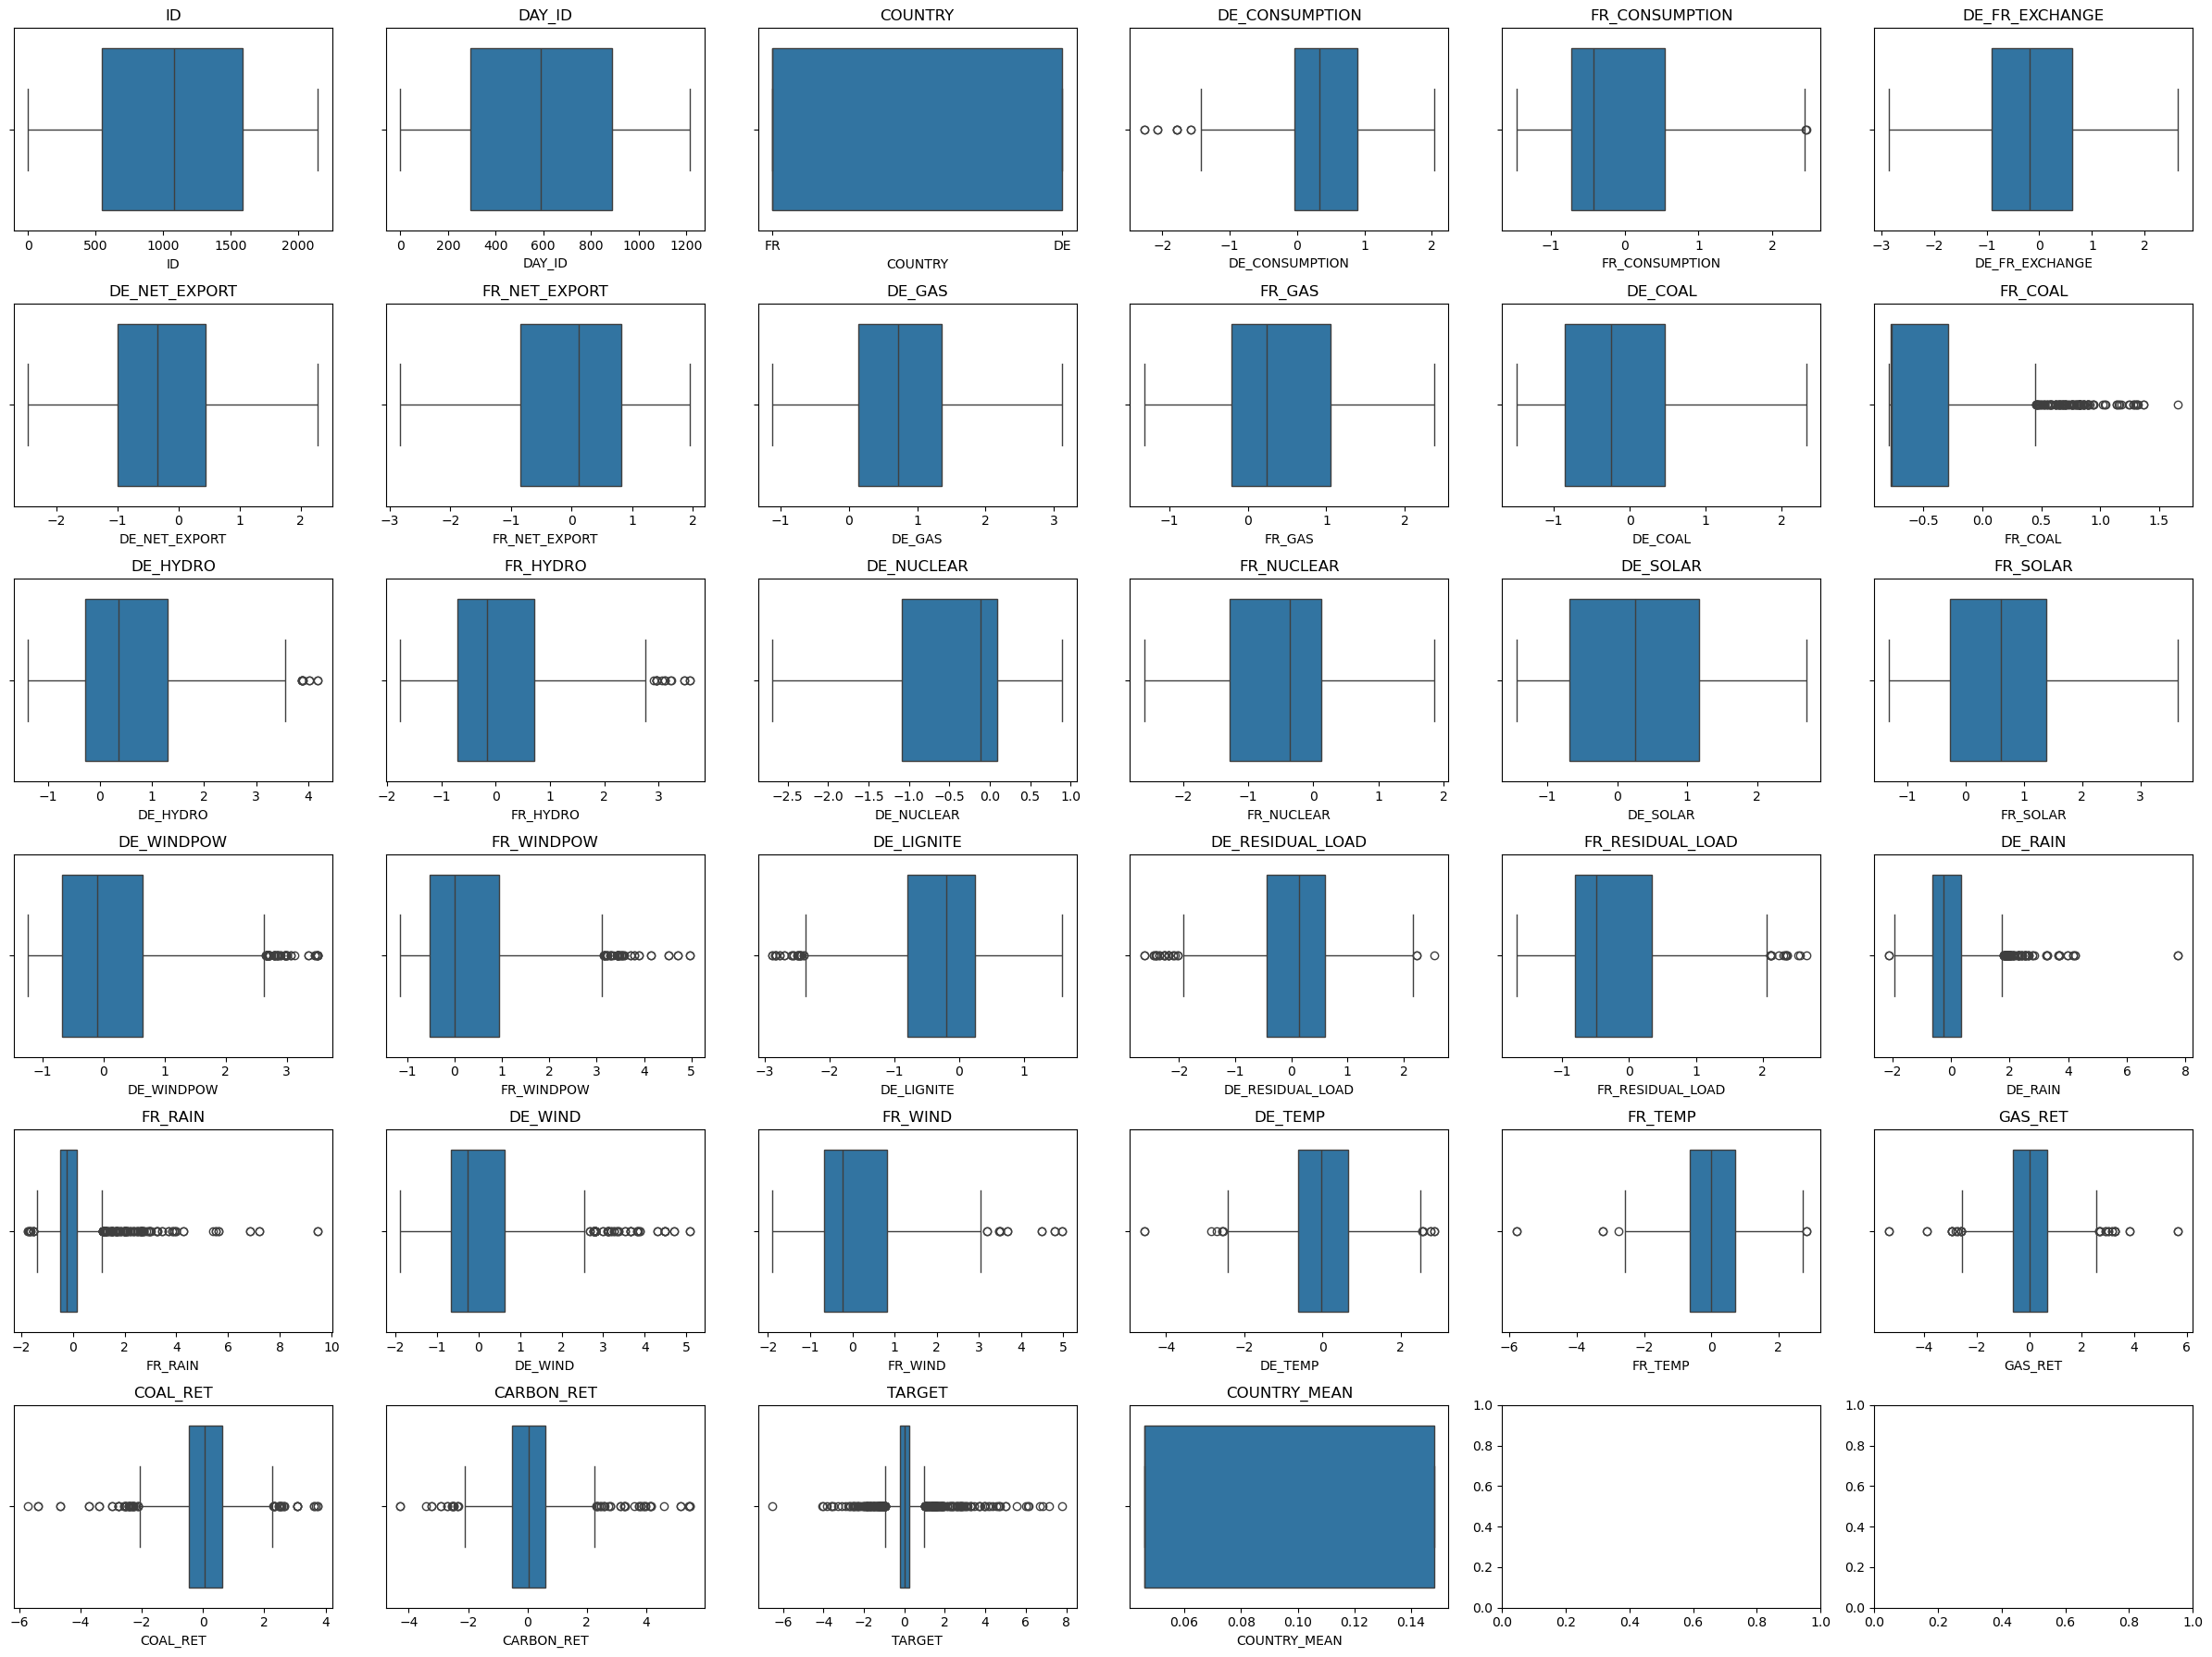

In [13]:
# plot the outliers for each feature
plots = [(c, X_y_train[c]) for c in X_y_train.columns]

K = len(plots)
N = math.ceil(math.sqrt(K))            
M = math.ceil(K / N)                 

fig, axes = plt.subplots(M, N, figsize=(N*4, M*3), squeeze=False)
axes = axes.ravel()

for i, (name, s) in enumerate(plots):
    sns.boxplot(x=s, ax=axes[i])
    axes[i].set_title(f"{name}")

plt.tight_layout()
plt.show()

## 3. Handling Missing Values

### 3.1 Check Missing Values 

List features with missing values:


missing_count  missing_pct
DE_NET_EXPORT             166     0.078561
DE_WIND                   104     0.049219
FR_WIND                   104     0.049219
DE_TEMP                   104     0.049219
FR_TEMP                   104     0.049219
FR_RAIN                   104     0.049219
DE_RAIN                   104     0.049219
FR_NET_EXPORT              89     0.042120
DE_FR_EXCHANGE             30     0.014198

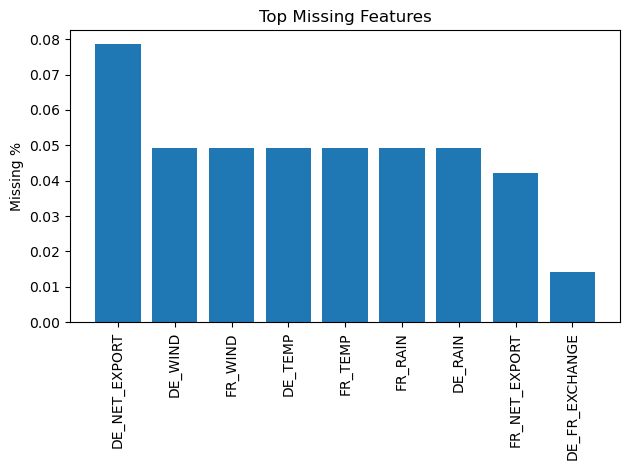

In [14]:
# list top missing features
missing_counts = X_train_test.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(X_train_test)).sort_values(ascending=False)
missing_df = pd.DataFrame({"missing_count": missing_counts, "missing_pct": missing_pct})
print("List features with missing values:")
display(missing_df[missing_df.missing_count	> 0])

# plot top missing features — single figure
top_miss = missing_df.head((missing_df['missing_count'] > 0).sum())
plt.figure()
plt.bar(top_miss.index.astype(str), top_miss["missing_pct"].values)
plt.xticks(rotation=90)
plt.ylabel("Missing %")
plt.title("Top Missing Features")
plt.tight_layout()
plt.show()

### 3.2 Imputation of missing values

In the missing-data impulation section, we implemented and compared the following methods: null impulation ('zero'), mean impulation ('mean'), median impulation ('median'), multivariate Imputation ('mice'), K-Nearest Neighbor ('knn'), interpolation & extrapolation ('interp'). We also distinguished between two impulation scenarios: (1) the standard approach where the training and test sets are handled separately, and (2) combining the two datasets to form a complete time series and performing impulation on that series. In the second scenario, we first standardize the time series and then interpolate, finally merging the results back into the original datasets keyed by 'DAY_ID'. This ensures that feature values for the same day are consistent, thereby preserving the original data logic.

In [15]:
# impute missing values with different methods
imp_cols = num_cols[:-1]

if UseTimeSeries:
    # provide and sort complete time series of train and test data set
    df_timeseries = X_train_test[imp_cols].copy()
    df_timeseries.sort_values("DAY_ID", inplace=True)
    df_timeseries.drop_duplicates(inplace=True)
    print(f"There are {len(df_timeseries[df_timeseries.duplicated(subset=['DAY_ID'], keep=False)])} duplicates in the time series")

    # impute missing values
    X_filled_zero = SimpleFill(fill_method='zero').fit_transform(df_timeseries)
    X_filled_mean = SimpleFill(fill_method='mean').fit_transform(df_timeseries)
    X_filled_median = SimpleFill(fill_method='median').fit_transform(df_timeseries)
    X_filled_mice = IterativeImputer(max_iter=10, random_state=RANDOM_STATE).fit_transform(df_timeseries)
    X_filled_knn = KNN(k=5).fit_transform(df_timeseries)
    X_filled_interp = df_timeseries.interpolate(method='polynomial', order=2, limit_direction="both")
    X_filled_interp = X_filled_interp.interpolate(method="linear", limit_direction="both")

    X_filled_zero = pd.DataFrame(X_filled_zero, columns=imp_cols)
    X_filled_mean = pd.DataFrame(X_filled_mean, columns=imp_cols)
    X_filled_median = pd.DataFrame(X_filled_median, columns=imp_cols)
    X_filled_mice = pd.DataFrame(X_filled_mice, columns=imp_cols)
    X_filled_knn = pd.DataFrame(X_filled_knn, columns=imp_cols)
else:
    imp_cols_id = imp_cols + ['ID']
    X_train_imp = X_train[['ID']].merge(X_train_test, on='ID', how='left')[imp_cols_id]
    X_test_imp = X_test[['ID']].merge(X_train_test, on='ID', how='left')[imp_cols_id]
    
    X_tr_filled_zero = SimpleFill(fill_method='zero').fit_transform(X_train_imp)
    X_tr_filled_mean = SimpleFill(fill_method='mean').fit_transform(X_train_imp)
    X_tr_filled_median = SimpleFill(fill_method='median').fit_transform(X_train_imp)
    X_tr_filled_mice = IterativeImputer(max_iter=10, random_state=RANDOM_STATE).fit_transform(X_train_imp)
    X_tr_filled_knn = KNN(k=5).fit_transform(X_train_imp)
    X_tr_filled_interp = X_train.interpolate(method='polynomial',order=3).fillna(0.0)
    
    X_tr_filled_zero = pd.DataFrame(X_tr_filled_zero, columns=imp_cols_id)
    X_tr_filled_mean = pd.DataFrame(X_tr_filled_mean, columns=imp_cols_id)
    X_tr_filled_median = pd.DataFrame(X_tr_filled_median, columns=imp_cols_id)
    X_tr_filled_mice = pd.DataFrame(X_tr_filled_mice, columns=imp_cols_id)
    X_tr_filled_knn = pd.DataFrame(X_tr_filled_knn, columns=imp_cols_id)

    X_te_filled_zero = SimpleFill(fill_method='zero').fit_transform(X_test_imp)
    X_te_filled_mean = SimpleFill(fill_method='mean').fit_transform(X_test_imp)
    X_te_filled_median = SimpleFill(fill_method='median').fit_transform(X_test_imp)
    X_te_filled_mice = IterativeImputer(max_iter=10, random_state=RANDOM_STATE).fit_transform(X_test_imp)
    X_te_filled_knn = KNN(k=5).fit_transform(X_test_imp)
    X_te_filled_interp = X_test.interpolate(method='polynomial',order=3)

    X_te_filled_zero = pd.DataFrame(X_te_filled_zero, columns=imp_cols_id)
    X_te_filled_mean = pd.DataFrame(X_te_filled_mean, columns=imp_cols_id)
    X_te_filled_median = pd.DataFrame(X_te_filled_median, columns=imp_cols_id)
    X_te_filled_mice = pd.DataFrame(X_te_filled_mice, columns=imp_cols_id)
    X_te_filled_knn = pd.DataFrame(X_te_filled_knn, columns=imp_cols_id)

    X_filled_zero = pd.concat([X_tr_filled_zero, X_te_filled_zero], ignore_index=True)
    X_filled_mean = pd.concat([X_tr_filled_mean, X_te_filled_mean], ignore_index=True)
    X_filled_median = pd.concat([X_tr_filled_median, X_te_filled_median], ignore_index=True)
    X_filled_mice = pd.concat([X_tr_filled_mice, X_te_filled_mice], ignore_index=True)
    X_filled_knn = pd.concat([X_tr_filled_knn, X_te_filled_knn], ignore_index=True)
    X_filled_interp = pd.concat([X_tr_filled_interp, X_te_filled_interp], ignore_index=True).fillna(0.0)

There are 0 duplicates in the time series


Imputing row 1/1199 with 1 missing, elapsed time: 0.150
Imputing row 101/1199 with 0 missing, elapsed time: 0.152
Imputing row 201/1199 with 0 missing, elapsed time: 0.153
Imputing row 301/1199 with 6 missing, elapsed time: 0.154
Imputing row 401/1199 with 6 missing, elapsed time: 0.155
Imputing row 501/1199 with 0 missing, elapsed time: 0.155
Imputing row 601/1199 with 0 missing, elapsed time: 0.155
Imputing row 701/1199 with 0 missing, elapsed time: 0.155
Imputing row 801/1199 with 0 missing, elapsed time: 0.156
Imputing row 901/1199 with 0 missing, elapsed time: 0.156
Imputing row 1001/1199 with 1 missing, elapsed time: 0.157
Imputing row 1101/1199 with 0 missing, elapsed time: 0.157


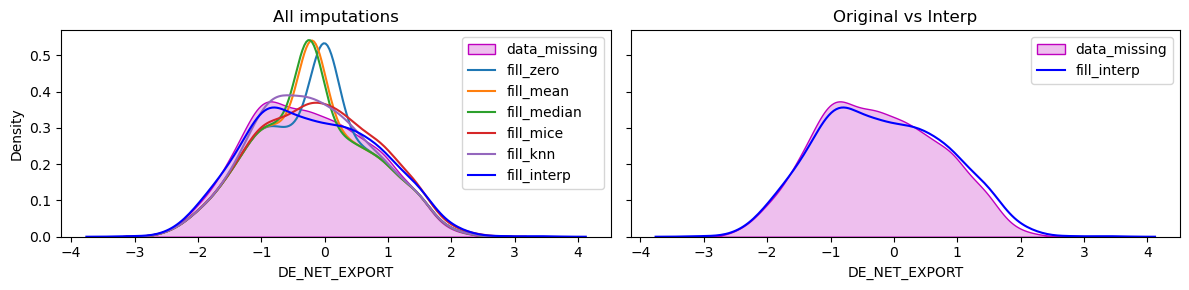

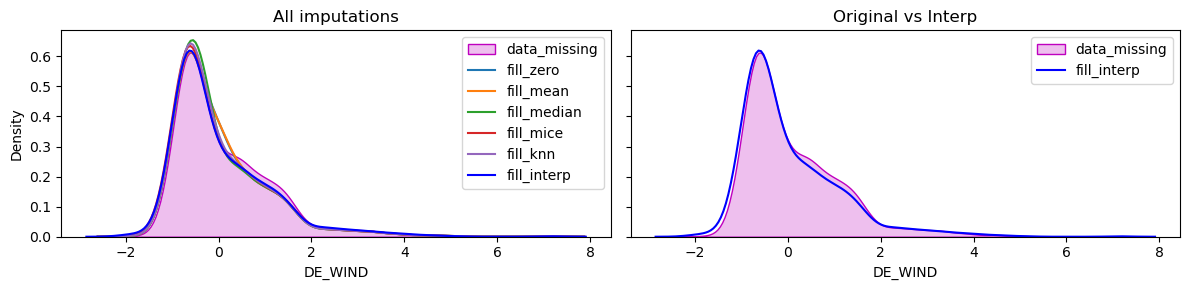

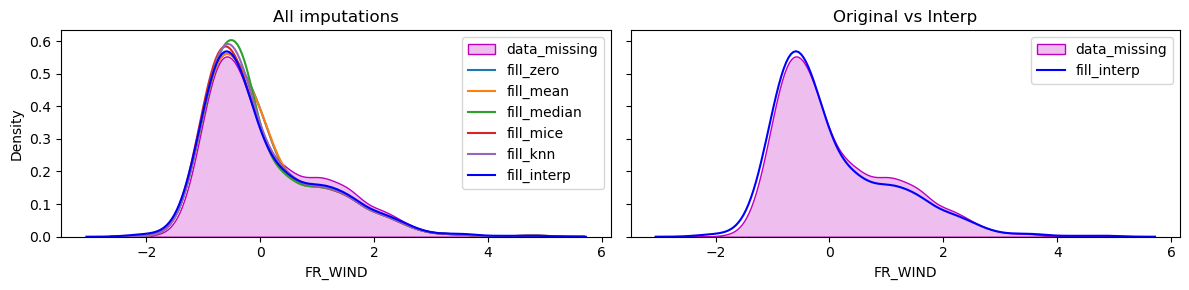

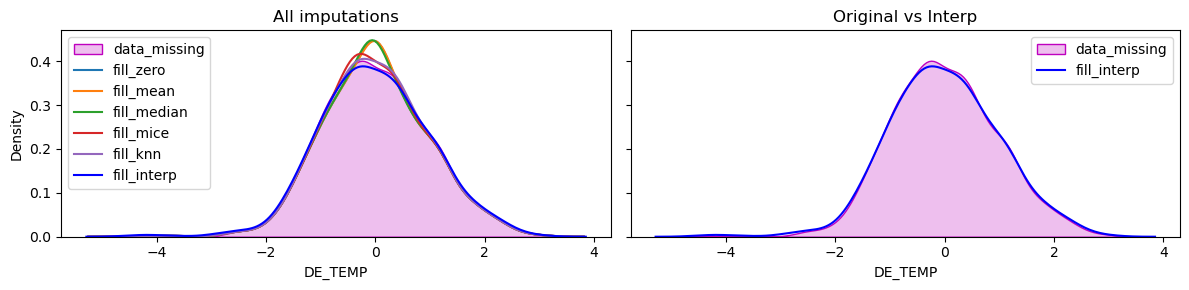

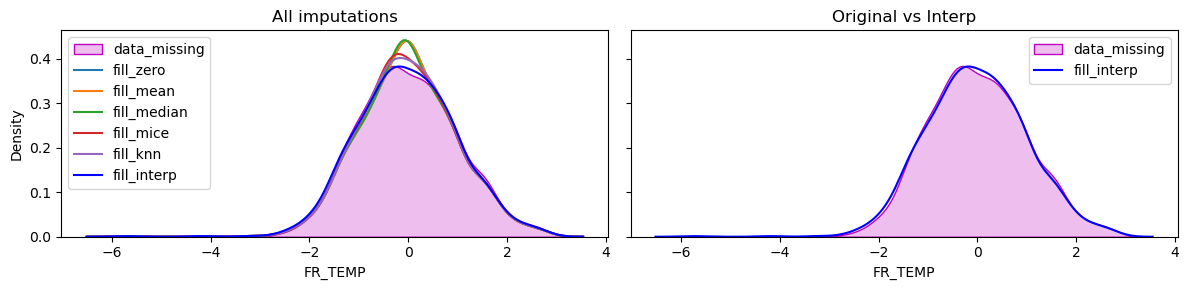

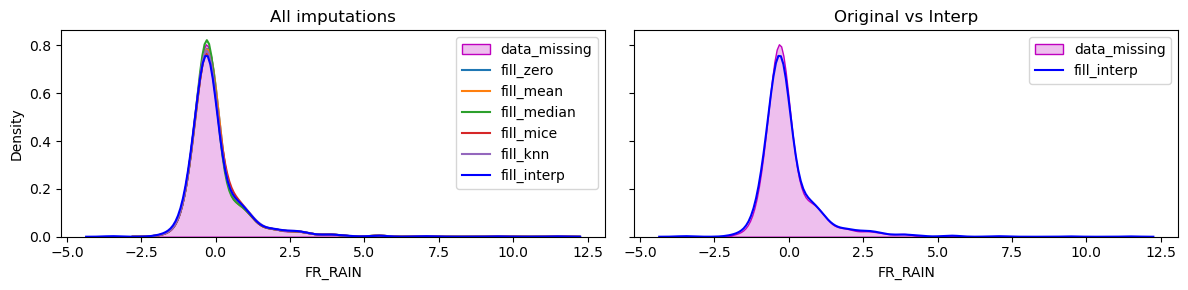

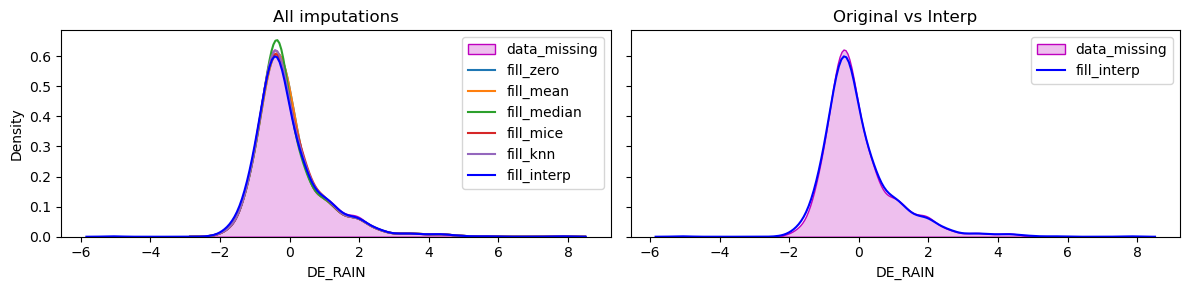

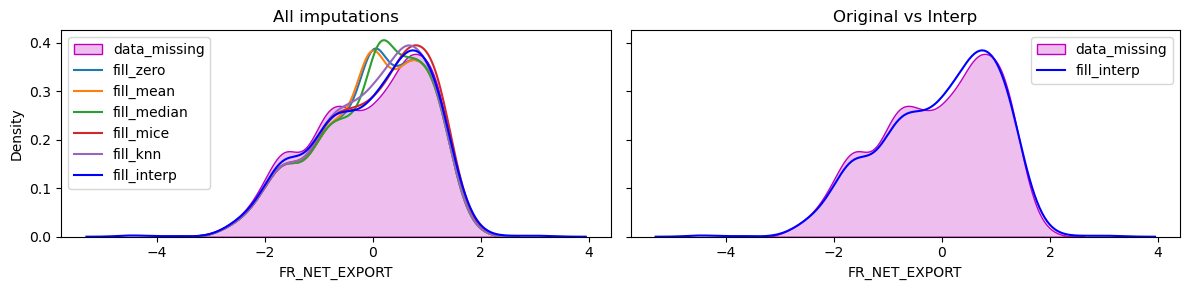

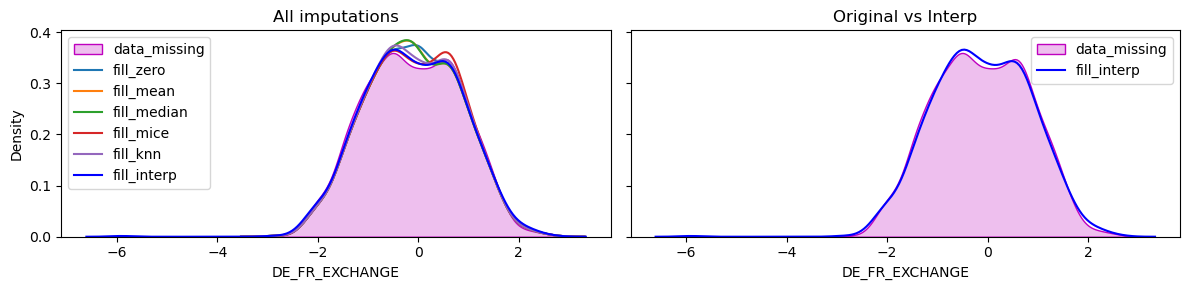

In [16]:
# plot distribution between features before and after imputation
for c in top_miss.index:
    fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
    ax1, ax2 = axes
    
    sns.kdeplot(X_train_test[imp_cols][c], color='m', fill=True, ax=ax1, label='data_missing')
    sns.kdeplot(X_filled_zero[c],   ax=ax1, label='fill_zero')
    sns.kdeplot(X_filled_mean[c],   ax=ax1, label='fill_mean')
    sns.kdeplot(X_filled_median[c], ax=ax1, label='fill_median')
    sns.kdeplot(X_filled_mice[c],   ax=ax1, label='fill_mice')
    sns.kdeplot(X_filled_knn[c],    ax=ax1, label='fill_knn')
    sns.kdeplot(X_filled_interp[c], color='b', ax=ax1, label='fill_interp')
    ax1.set_xlabel(c)
    ax1.set_title('All imputations')
    ax1.legend()
    
    sns.kdeplot(X_train_test[c],    color='m', fill=True, ax=ax2, label='data_missing')
    sns.kdeplot(X_filled_interp[c], color='b', ax=ax2, label='fill_interp')
    ax2.set_xlabel(c)
    ax2.set_title('Original vs Interp')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [17]:
if UseTimeSeries:
    X_train_test_filled = pd.merge(X_train_test[['ID', 'DAY_ID', 'COUNTRY', 'COUNTRY_MEAN']], eval(f"X_filled_{impute_method}"), on='DAY_ID', how='left') 
elif impute_method == 'interp':
    X_train_test_filled = pd.merge(X_train_test[['ID', 'COUNTRY_MEAN']], eval(f"X_filled_{impute_method}"), on='ID', how='left')
else:
    X_train_test_filled = pd.merge(X_train_test[['ID', 'COUNTRY', 'COUNTRY_MEAN']], eval(f"X_filled_{impute_method}"), on='ID', how='left') 

In [18]:
X_filled_interp

DAY_ID  DE_CONSUMPTION  FR_CONSUMPTION  DE_FR_EXCHANGE  DE_NET_EXPORT  \
742        0        0.048418       -0.465067       -0.079296       0.148088   
1211       1        0.966997        1.222131        0.331356       0.405549   
1408       2       -0.068972       -0.667390       -1.102015      -1.080403   
680        3       -0.134670       -0.834564       -1.051716      -1.881881   
1725       4        0.944117        0.203547        0.372743       0.656335   
...      ...             ...             ...             ...            ...   
1815    1211       -0.260011       -1.022730       -1.208286      -1.203534   
1007    1212       -0.046100       -0.520506       -0.270515      -0.137917   
1465    1213        1.407027        1.313254       -0.456126       0.333142   
1495    1214        0.803209        0.780411        0.601610       0.342802   
1437    1215        0.544810       -0.378158       -0.065993      -0.903824   

      FR_NET_EXPORT    DE_GAS    FR_GAS   DE_COAL   FR_COAL  ...  \
742        0.650577  0.592572 -0.261565  0.534535  0.095197  ...   
1211       0.778627  1.111008  1.991028  0.660390 -0.786509  ...   
1408       0.256736  1.228079  0.458302 -0.247704 -0.766904  ...   
680       -0.612133  1.588542  0.069297 -0.635452 -0.718729  ...   
1725       0.519380  0.451085  0.865857 -0.752504 -0.782998  ...   
...             ...       ...       ...       ...       ...  ...   
1815       1.170144  0.574809 -0.716954 -1.343261 -0.781600  ...   
1007      -0.789824  0.231723  0.625656 -0.491812 -0.776785  ...   
1465      -0.069222  1.781433  1.549682 -0.451947 -0.291751  ...   
1495       0.555367  1.064102  1.807256  0.089534 -0.792111  ...   
1437       0.257829  0.233317 -0.014042  0.872465  0.376881  ...   

      FR_RESIDUAL_LOAD   DE_RAIN   FR_RAIN   DE_WIND   FR_WIND   DE_TEMP  \
742          -0.344706 -0.987968 -0.856204 -0.655528 -1.099226  0.279885   
1211          1.214288 -0.370990 -0.497520 -1.184018 -1.465608  1.349212   
1408         -0.540642 -0.344600 -0.372156 -0.623041 -0.926064 -0.148950   
680          -0.856321 -1.394561 -1.118297  0.244859  0.488650 -1.710888   
1725         -0.052684 -0.900802 -0.359430 -0.614570 -0.734964  1.192221   
...                ...       ...       ...       ...       ...       ...   
1815         -1.051760 -0.525565 -0.337370 -0.415788 -0.627293 -1.015212   
1007         -0.589767 -0.039379 -0.237434  1.358211  1.123953 -0.707839   
1465          0.868310  0.150020  0.487553  4.143977  2.411556  2.232073   
1495          0.857739 -0.340595 -0.301094 -0.759816 -1.221443 -0.616617   
1437         -0.223383 -0.646163  0.738201 -0.903380 -0.882630 -0.247278   

       FR_TEMP   GAS_RET  COAL_RET  CARBON_RET  
742   0.583874 -1.071996 -0.074767    0.798003  
1211  0.231602  1.480313  0.931562    0.822047  
1408  0.641235  1.802550  1.140920    0.900434  
680  -0.951057  0.440121 -0.064550   -0.032756  
1725  0.701597 -0.357747  0.696316   -0.426880  
...        ...       ...       ...         ...  
1815  0.642532  0.698900 -0.120277    0.543710  
1007 -0.308232  0.017778  0.072168   -0.160792  
1465 -0.092500 -0.103642 -0.633007    0.214805  
1495 -0.737496  0.251251  0.753646    0.664086  
1437  0.755489  0.758698  0.078518    0.192945  

[1199 rows x 30 columns]

### 3.3 Statistic after Imputation

Missing value count: 0
Correlation matrix shape: (32, 32)


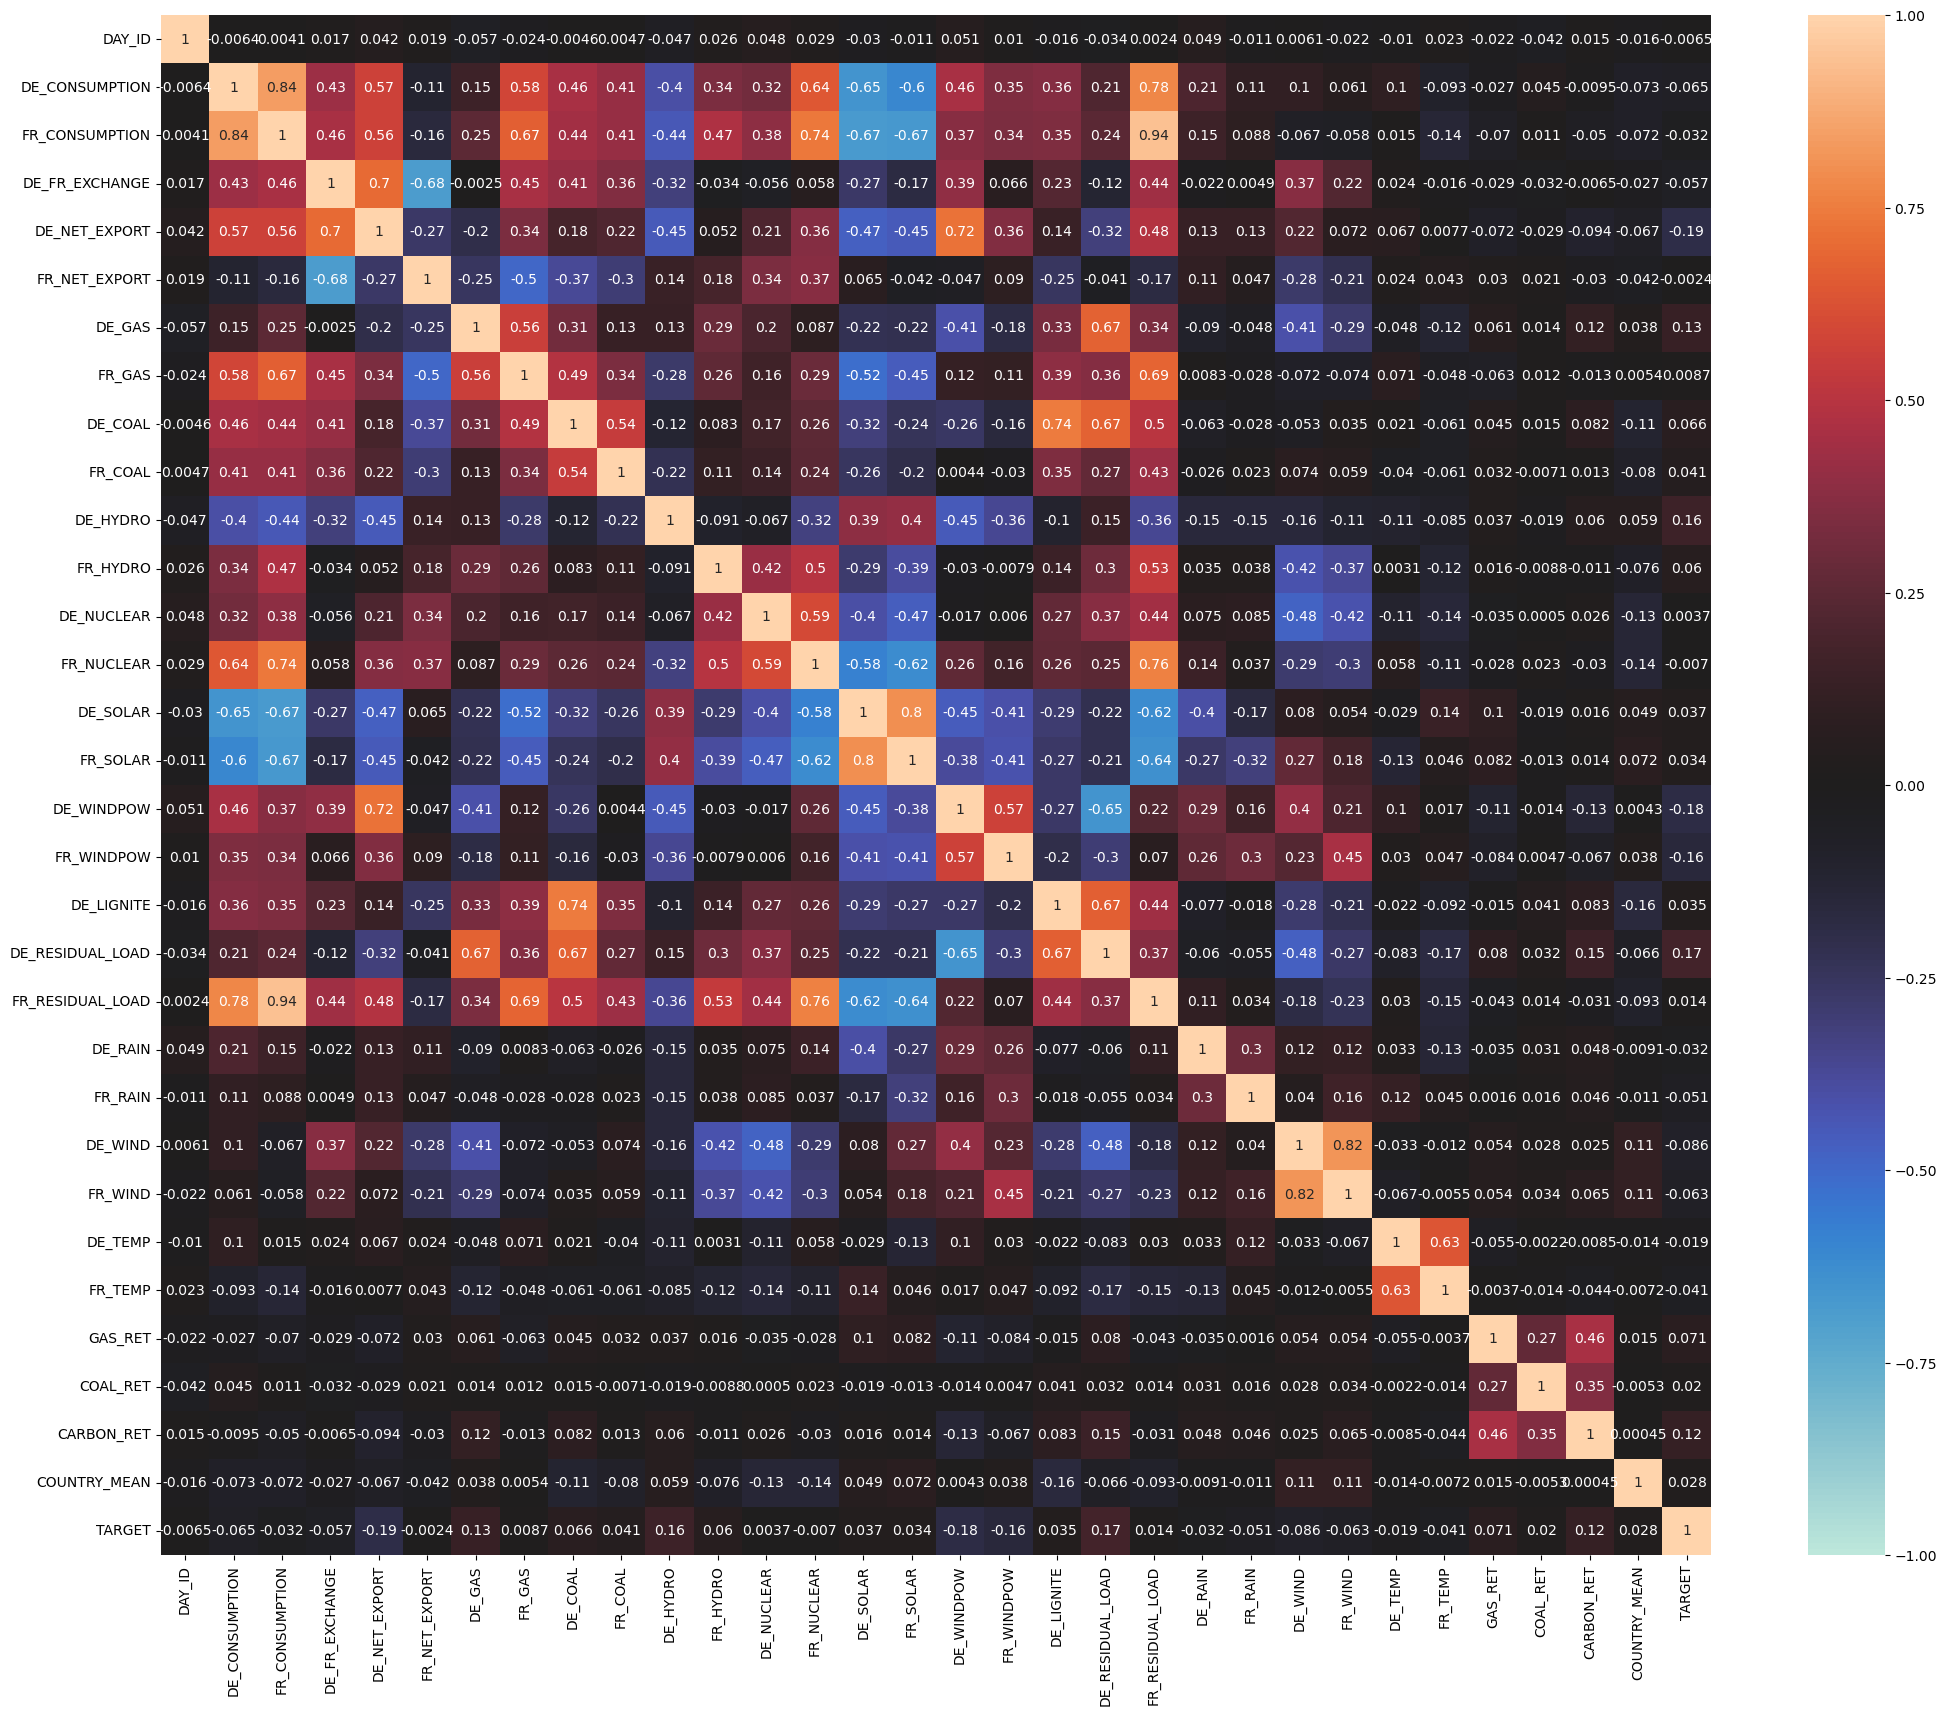

In [19]:
# plot heatmap of train data with target after imputation
X_y_train_filled = pd.merge(X_train_test_filled, y_train, on='ID', how='right')
print("Missing value count:", X_y_train_filled.isna().sum().sum())

corr = X_y_train_filled[num_cols + ["TARGET"]].corr(method=parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0) 
plt.show()

In [20]:
# top absolute correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:20]
display(pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"]))

feat1             feat2       |r|         r
0   FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.938138  0.938138
1   DE_CONSUMPTION    FR_CONSUMPTION  0.839542  0.839542
2          DE_WIND           FR_WIND  0.815455  0.815455
3         DE_SOLAR          FR_SOLAR  0.803456  0.803456
4   DE_CONSUMPTION  FR_RESIDUAL_LOAD  0.777488  0.777488
5       FR_NUCLEAR  FR_RESIDUAL_LOAD  0.758214  0.758214
6          DE_COAL        DE_LIGNITE  0.744455  0.744455
7   FR_CONSUMPTION        FR_NUCLEAR  0.737059  0.737059
8    DE_NET_EXPORT        DE_WINDPOW  0.721638  0.721638
9   DE_FR_EXCHANGE     DE_NET_EXPORT  0.700371  0.700371
10          FR_GAS  FR_RESIDUAL_LOAD  0.687070  0.687070
11  DE_FR_EXCHANGE     FR_NET_EXPORT  0.680638 -0.680638
12  FR_CONSUMPTION          DE_SOLAR  0.673819 -0.673819
13          DE_GAS  DE_RESIDUAL_LOAD  0.673635  0.673635
14         DE_COAL  DE_RESIDUAL_LOAD  0.673296  0.673296
15  FR_CONSUMPTION          FR_SOLAR  0.670592 -0.670592
16      DE_LIGNITE  DE_RESIDUAL_LOAD  0.670536  0.670536
17  FR_CONSUMPTION            FR_GAS  0.668793  0.668793
18      DE_WINDPOW  DE_RESIDUAL_LOAD  0.650217 -0.650217
19  DE_CONSUMPTION          DE_SOLAR  0.649372 -0.649372

DE_RESIDUAL_LOAD    0.173904
DE_HYDRO            0.155540
DE_GAS              0.126673
CARBON_RET          0.120927
GAS_RET             0.070996
DE_COAL             0.066406
FR_HYDRO            0.060309
FR_COAL             0.041315
DE_SOLAR            0.037432
DE_LIGNITE          0.035245
FR_SOLAR            0.033704
COUNTRY_MEAN        0.028346
COAL_RET            0.019586
FR_RESIDUAL_LOAD    0.014340
FR_GAS              0.008651
DE_NUCLEAR          0.003714
FR_NET_EXPORT      -0.002370
DAY_ID             -0.006510
FR_NUCLEAR         -0.007009
DE_TEMP            -0.018531
DE_RAIN            -0.031664
FR_CONSUMPTION     -0.031764
FR_TEMP            -0.041118
FR_RAIN            -0.051135
DE_FR_EXCHANGE     -0.056837
FR_WIND            -0.062519
DE_CONSUMPTION     -0.064612
DE_WIND            -0.085541
FR_WINDPOW         -0.155484
DE_WINDPOW         -0.184884
DE_NET_EXPORT      -0.192245
Name: TARGET, dtype: float64

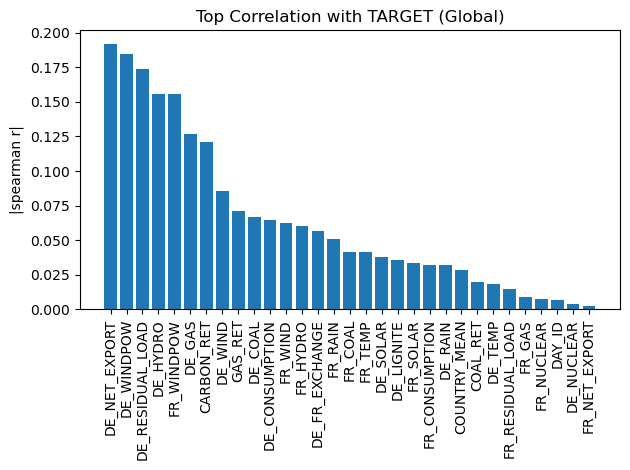

In [21]:
# calculate correlations between features and target, plot the top target correlations
assert "TARGET" in X_y_train_filled.columns, "TARGET missing after merge"
target_corr = X_y_train_filled[num_cols + ["TARGET"]].corr(method=parameters['corr_method'])["TARGET"].drop("TARGET").sort_values(ascending=False)
display(target_corr)

# Bar of absolute correlations (top-k)
tc_abs = target_corr.abs().sort_values(ascending=False)
plt.figure()
plt.bar(tc_abs.index.astype(str), tc_abs.values)
plt.xticks(rotation=90)
plt.ylabel(f"|{parameters['corr_method']} r|")
plt.title("Top Correlation with TARGET (Global)")
plt.tight_layout()
plt.show()

DE_RESIDUAL_LOAD    0.065481
DE_WIND             0.061779
FR_NET_EXPORT       0.054733
DE_WINDPOW          0.052226
DE_RAIN             0.044811
DAY_ID              0.042201
DE_LIGNITE          0.041609
DE_GAS              0.038693
FR_CONSUMPTION      0.027433
FR_WINDPOW          0.027051
DE_TEMP             0.025642
COUNTRY_MEAN        0.024536
FR_WIND             0.024529
DE_CONSUMPTION      0.019471
DE_NET_EXPORT       0.018865
GAS_RET             0.018011
FR_SOLAR            0.017687
FR_NUCLEAR          0.016405
CARBON_RET          0.015741
FR_COAL             0.014339
DE_COAL             0.011992
DE_NUCLEAR          0.009052
DE_HYDRO            0.007694
FR_RAIN             0.007688
DE_SOLAR            0.007376
FR_GAS              0.006798
FR_HYDRO            0.006238
DE_FR_EXCHANGE      0.000000
FR_RESIDUAL_LOAD    0.000000
FR_TEMP             0.000000
COAL_RET            0.000000
dtype: float64

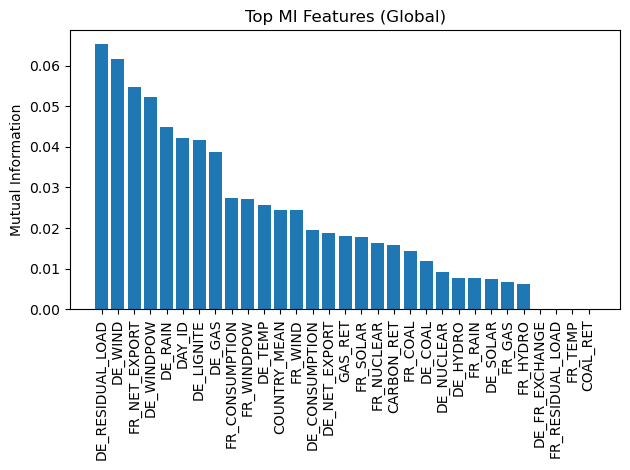

In [22]:
# mutual Information ranking (top-k) of the train data set after imputation
mi = mutual_info_regression(X_y_train_filled[num_cols], X_y_train_filled['TARGET'], random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=num_cols).sort_values(ascending=False)
display(mi_series)

plt.figure()
plt.bar(mi_series.index.astype(str), mi_series.values)
plt.xticks(rotation=90)
plt.ylabel("Mutual Information")
plt.title("Top MI Features (Global)")
plt.tight_layout()
plt.show()

Correlation matrix shape: (31, 31)


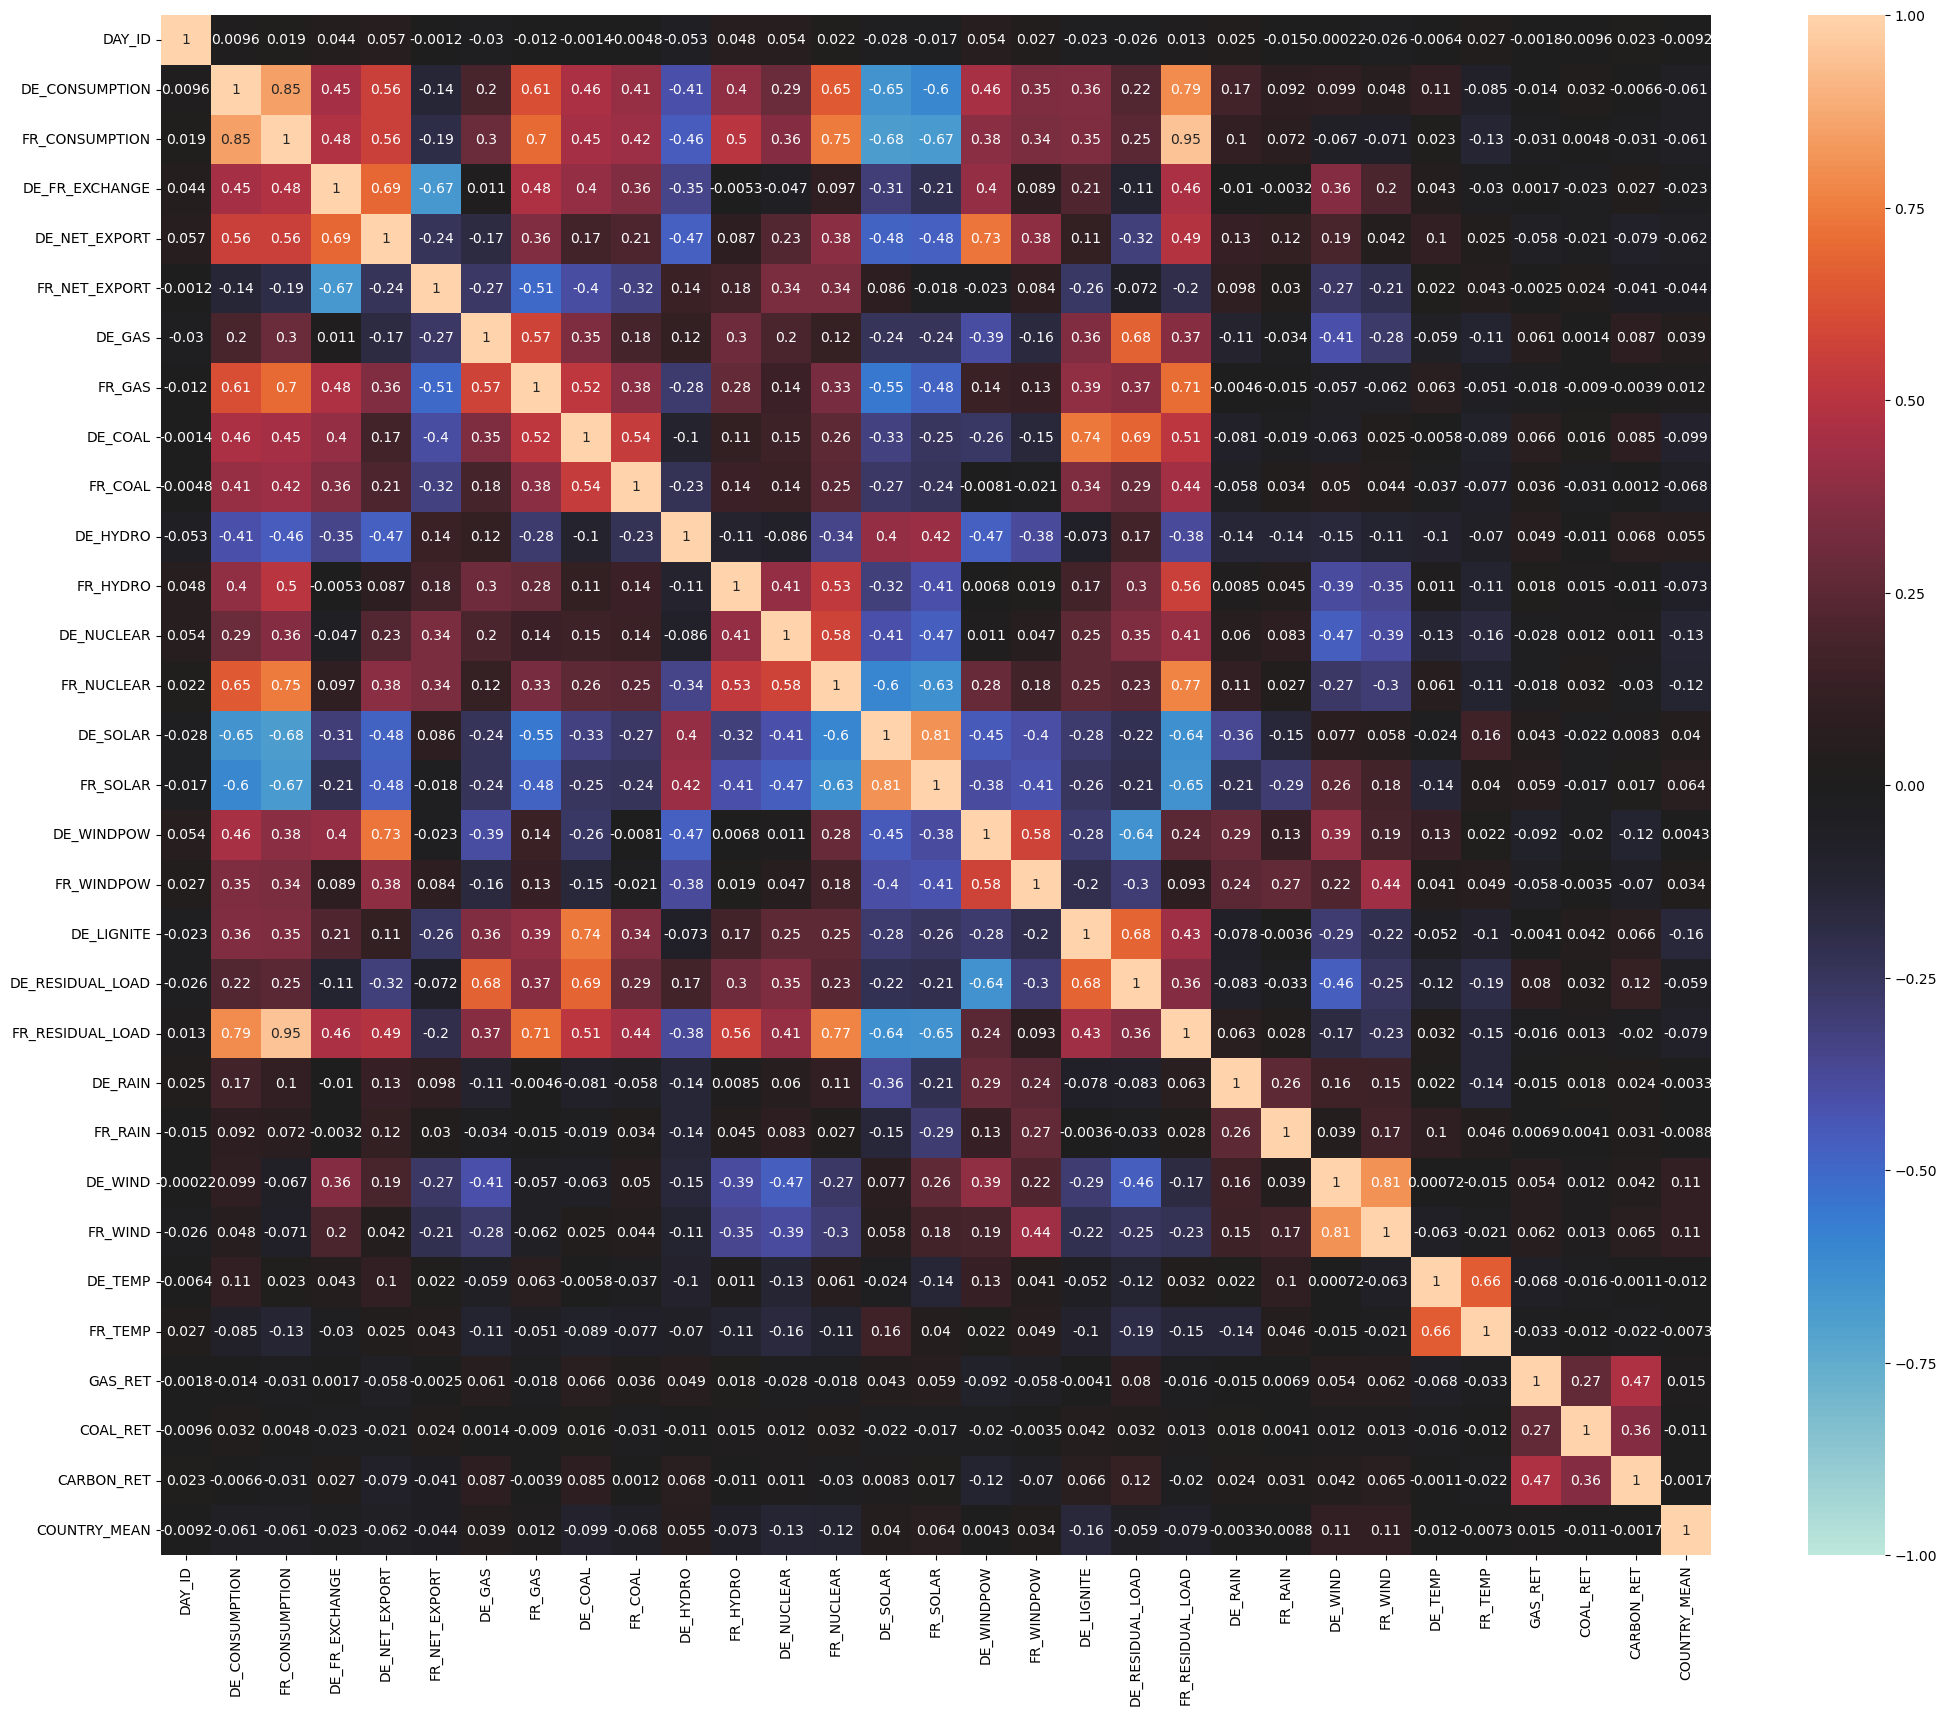

In [23]:
# plot heatmap of train and test data set after imputation
corr = X_train_test_filled[num_cols].corr(method=parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0) 
plt.show()

In [24]:
# Top correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:20]
display(pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"]))

feat1             feat2       |r|         r
0   FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.946473  0.946473
1   DE_CONSUMPTION    FR_CONSUMPTION  0.845925  0.845925
2         DE_SOLAR          FR_SOLAR  0.812114  0.812114
3          DE_WIND           FR_WIND  0.809453  0.809453
4   DE_CONSUMPTION  FR_RESIDUAL_LOAD  0.791239  0.791239
5       FR_NUCLEAR  FR_RESIDUAL_LOAD  0.770914  0.770914
6   FR_CONSUMPTION        FR_NUCLEAR  0.748247  0.748247
7          DE_COAL        DE_LIGNITE  0.742105  0.742105
8    DE_NET_EXPORT        DE_WINDPOW  0.729298  0.729298
9           FR_GAS  FR_RESIDUAL_LOAD  0.710390  0.710390
10  FR_CONSUMPTION            FR_GAS  0.700188  0.700188
11  DE_FR_EXCHANGE     DE_NET_EXPORT  0.687909  0.687909
12         DE_COAL  DE_RESIDUAL_LOAD  0.686504  0.686504
13      DE_LIGNITE  DE_RESIDUAL_LOAD  0.681856  0.681856
14  FR_CONSUMPTION          DE_SOLAR  0.681668 -0.681668
15          DE_GAS  DE_RESIDUAL_LOAD  0.677526  0.677526
16  FR_CONSUMPTION          FR_SOLAR  0.674808 -0.674808
17  DE_FR_EXCHANGE     FR_NET_EXPORT  0.668168 -0.668168
18         DE_TEMP           FR_TEMP  0.662943  0.662943
19  DE_CONSUMPTION        FR_NUCLEAR  0.652522  0.652522

## 4. Creating Features

### 4.1 Add residual columns according to high correlations

In [25]:
df_sorted_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
df_top_corr = df_sorted_corr[df_sorted_corr["|r|"] > corr_threshold]
df_top_corr

feat1             feat2       |r|         r
0  FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.946473  0.946473

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

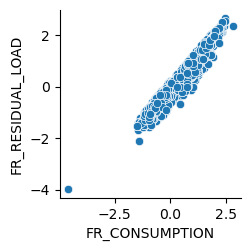

In [26]:
plt.clf()
plt.figure()
for idx, data in df_top_corr.iterrows():
    sns.pairplot(data=X_train_test_filled, x_vars=data.feat1, y_vars=data.feat2)
plt.show()

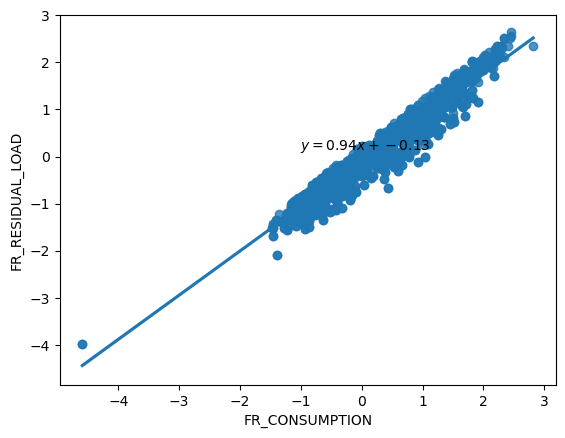

In [27]:
x_feature = df_top_corr.feat1.values[0]
y_feature = df_top_corr.feat2.values[0]

p = sns.regplot(x=x_feature, y=y_feature, data=X_train_test_filled)

#calculate slope and intercept of regression equation
slope, intercept, r, p, sterr = scipy.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                       y=p.get_lines()[0].get_ydata())

#add regression equation to plot
result_string = f"$y = {slope:.2f}x + {intercept:.2f}$"

plt.figtext(0.5, 0.6, result_string)
plt.show()

In [28]:
drop_features.append(y_feature)
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]
X_trte_engineered = X_train_test_filled.copy()
X_trte_engineered['RES_' + y_feature] = X_trte_engineered[y_feature] - (slope * X_trte_engineered[y_feature] + intercept)

### 4.2 Create features with golden combination characteristic

In [29]:
# create gold characteristics
for f in (de_features + fr_features + eu_features):
    if UseTimeSeries:
        f_mean_de = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'DE', f].mean()
        f_mean_fr = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'FR', f].mean()
        f_std_de = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'DE', f].std()
        f_std_fr = X_trte_engineered.loc[X_trte_engineered['COUNTRY'] == 'FR', f].std()
    else:
        df_temp = X_train[['ID']].merge(X_trte_engineered, on='ID', how='left')
        f_mean_de = df_temp.loc[df_temp['COUNTRY'] == 'DE', f].mean()
        f_mean_fr = df_temp.loc[df_temp['COUNTRY'] == 'FR', f].mean()
        f_std_de = df_temp.loc[df_temp['COUNTRY'] == 'DE', f].std()
        f_std_fr = df_temp.loc[df_temp['COUNTRY'] == 'FR', f].std()
        
    X_trte_engineered['GOLD_' + f] = X_trte_engineered.apply(lambda row: (row[f] - f_mean_de) / f_std_de if row.COUNTRY == 'DE' else (row[f] - f_mean_fr) / f_std_fr, axis=1)

### 4.3 Create features regarding target encoding

Group sum with target correlations as coefficient. There are five groups that need to be considered. They are EU commodity price variations, weather measures, electricity use metrics, renewable energy measures and non-renewable energy measures.

#### 4.3.1 Target encoding on EU commodity price variations

In [30]:
# target encoding
X_trte_engineered['TARENC_EU_RET'] = 0.0 
for f in eu_features:
    X_trte_engineered['TARENC_EU_RET'] += target_corr[f] * X_trte_engineered[f]

(2113, 63)

(1459, 64)

<Figure size 640x480 with 0 Axes>

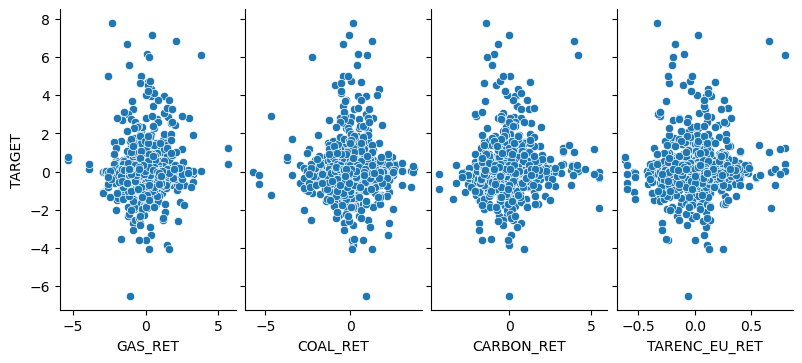

In [31]:
# plot features regarding EU commodity price variations
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=eu_features+['TARENC_EU_RET'], y_vars='TARGET')
diag.fig.set_size_inches(8, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.2 Target encoding on weather measures

In [32]:
# target encoding
X_trte_engineered['TARENC_WEATHER'] = 0.0 
for f in weather_features:
    X_trte_engineered['TARENC_WEATHER'] += target_corr[f] * X_trte_engineered[f]

(2113, 64)

(1459, 65)

<Figure size 640x480 with 0 Axes>

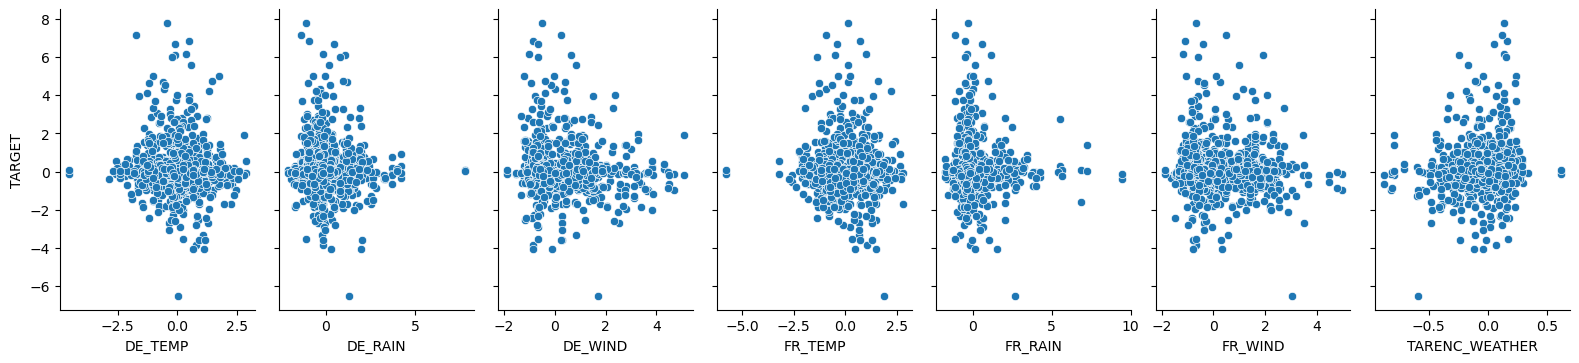

In [33]:
# plot features regarding weather measures
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=weather_features+['TARENC_WEATHER'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.3 Target encoding on electricity use metrics

In [34]:
# target encoding
X_trte_engineered['TARENC_USE'] = 0.0 
for f in use_features:
    X_trte_engineered['TARENC_USE'] += target_corr[f] * X_trte_engineered[f]

(2113, 65)

(1459, 66)

<Figure size 640x480 with 0 Axes>

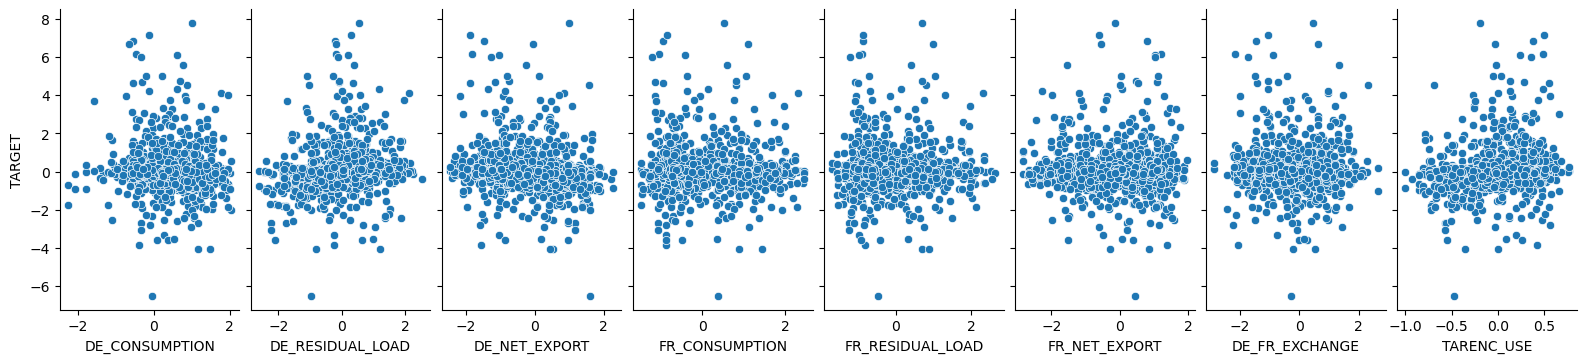

In [35]:
# plot features regarding electricity use metrics
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=use_features+['TARENC_USE'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.4 Target encoding on renewable energy measures

In [36]:
# target encoding
X_trte_engineered['TARENC_RENEW'] = 0.0 
for f in renew_features:
    X_trte_engineered['TARENC_RENEW'] += target_corr[f] * X_trte_engineered[f]

(2113, 66)

(1459, 67)

<Figure size 640x480 with 0 Axes>

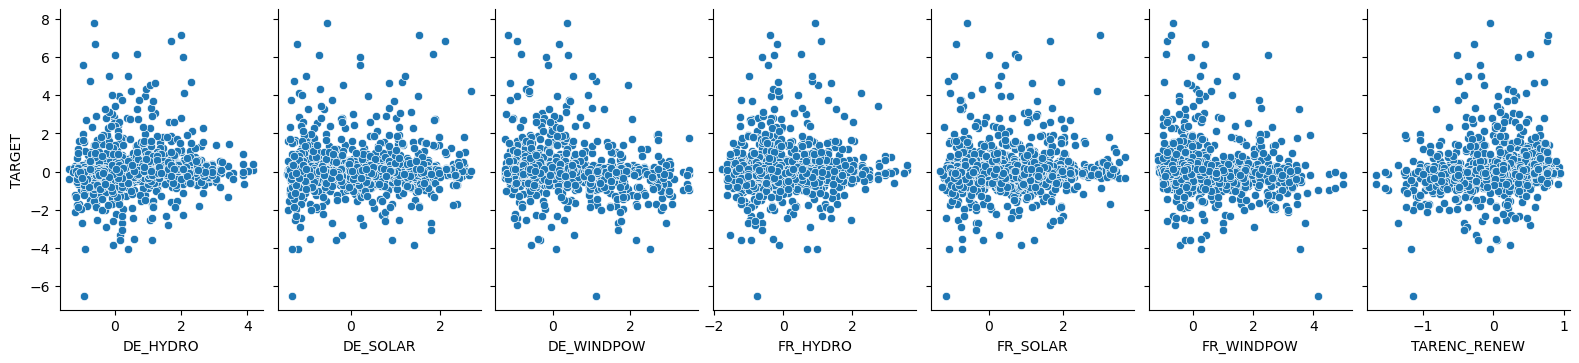

In [37]:
# plot features regarding renewable energy measures
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=renew_features+['TARENC_RENEW'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

#### 4.3.5 Target encoding on non-renewable energy measures

In [38]:
# target encoding
X_trte_engineered['TARENC_NONRENEW'] = 0.0 
for f in nonrenew_features:
    X_trte_engineered['TARENC_NONRENEW'] += target_corr[f] * X_trte_engineered[f]

(2113, 67)

(1459, 68)

<Figure size 640x480 with 0 Axes>

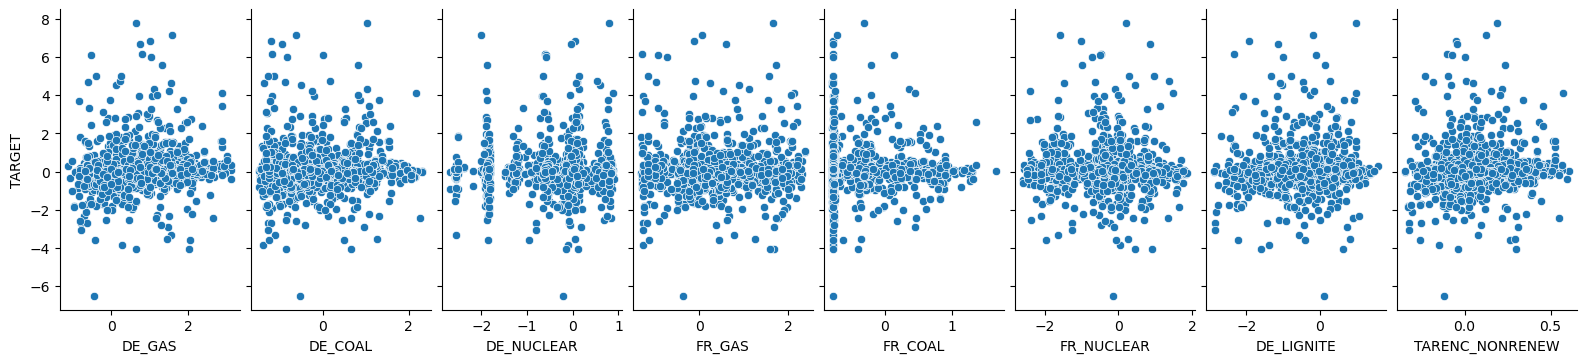

In [39]:
# plot features regarding non-renewable energy measures
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=nonrenew_features+['TARENC_NONRENEW'], y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

(2113, 68)

(1459, 69)

<Figure size 640x480 with 0 Axes>

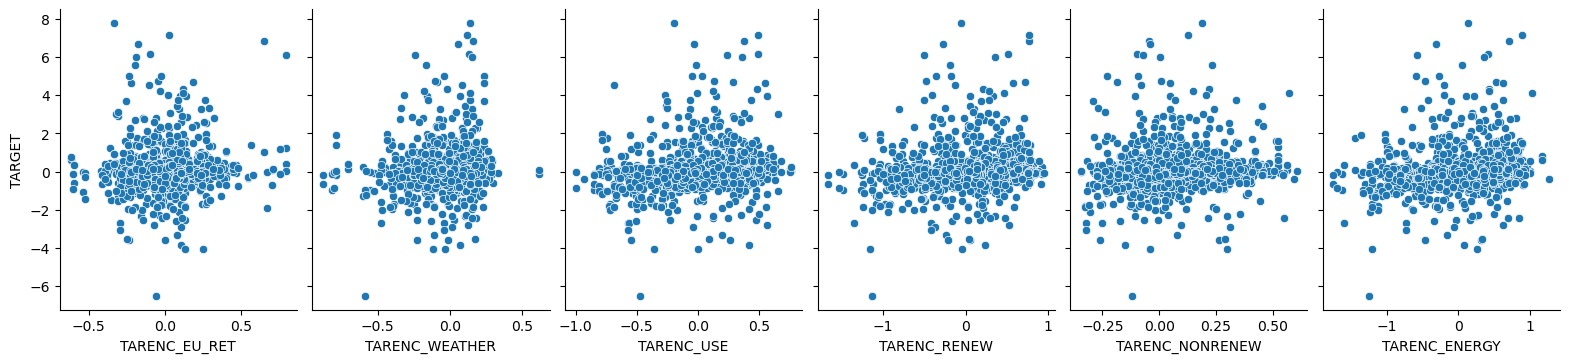

In [40]:
# plot all target encoding features
X_trte_engineered['TARENC_ENERGY'] = X_trte_engineered['TARENC_RENEW'] + X_trte_engineered['TARENC_NONRENEW']
Xy_tr_engineered = pd.merge(X_trte_engineered, y_train, on='ID', how='right')
display(X_trte_engineered.shape)
display(Xy_tr_engineered.shape)
target_encoding_list = [x for x in X_trte_engineered if 'TARENC_' in x]

plt.clf()
diag = sns.pairplot(data=Xy_tr_engineered, x_vars=target_encoding_list, y_vars='TARGET')
diag.fig.set_size_inches(16, 4)
diag.set(xlim=(None, None))
plt.show()

### 4.4 Add features based on 7-day-rolling

In [41]:
# check rolling duplicates
if UseTimeSeries:
    df_rolling = X_train_test_filled[num_cols[:-1]].copy()
    df_rolling.sort_values("DAY_ID", inplace=True)
    df_rolling.drop_duplicates(inplace=True)
    df_rolling[df_rolling.duplicated(subset=['DAY_ID'], keep=False)]

In [42]:
# carry out 7-day-rolling
if UseTimeSeries:
    for fea in num_cols[1:-1]: 
        if fea in df_rolling.columns:
            df_rolling[f"ROLL_{fea}"] = df_rolling[fea].rolling(7, min_periods=1).mean()
            df_rolling.drop(fea, axis=1, inplace=True)
    
    X_trte_engineered = pd.merge(X_trte_engineered, df_rolling, on='DAY_ID', how='left')

### 4.5 Create polynomial features for DE and FR data

In [43]:
# Split train and test data set by DE and FR 
X_trte_engineered_de = X_trte_engineered[X_trte_engineered['COUNTRY'] == 'DE']
X_trte_engineered_de.sort_values("DAY_ID", inplace=True)
X_trte_engineered_fr = X_trte_engineered[X_trte_engineered['COUNTRY'] == 'FR']
X_trte_engineered_fr.sort_values("DAY_ID", inplace=True)

y_train_de = Xy_tr_engineered.loc[Xy_tr_engineered['COUNTRY'] == 'DE', ['ID', 'TARGET']]
y_train_fr = Xy_tr_engineered.loc[Xy_tr_engineered['COUNTRY'] == 'FR', ['ID', 'TARGET']]

In [44]:
# polynomial features combined on DE and FR features
for fea in country_features:
    de = f"DE_{fea}"; fr = f"FR_{fea}"
    
    if de in X_trte_engineered_de.columns and fr in X_trte_engineered_de.columns:
        X_trte_engineered_de[f"DIFF_{fea}"] = X_trte_engineered_de[de] - X_trte_engineered_de[fr]
        X_trte_engineered_de[f"SUM_{fea}"] = X_trte_engineered_de[de] + X_trte_engineered_de[fr]

    if de in X_trte_engineered_fr.columns and fr in X_trte_engineered_fr.columns:
        X_trte_engineered_fr[f"DIFF_{fea}"] = X_trte_engineered_fr[fr] - X_trte_engineered_fr[de]
        X_trte_engineered_fr[f"SUM_{fea}"] = X_trte_engineered_fr[de] + X_trte_engineered_fr[fr]

In [45]:
# results obtained by merging DE and FR feature/target data and drop the 
X_trte_finished = pd.concat([X_trte_engineered_de, X_trte_engineered_fr], ignore_index=True).drop('COUNTRY', axis=1, inplace=False)

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

## 5. Feature selection

### 5.1 Remove features with low mutual info and high target correlation

In [46]:
# mutual information ranking (top-k)
mi = mutual_info_regression(Xy_tr_finished.drop('TARGET', axis=1), Xy_tr_finished['TARGET'], random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=Xy_tr_finished.columns[:-1]).sort_values(ascending=False)
df_mi = mi_series.to_frame('MI')
df_mi_zero = df_mi[df_mi.MI <= 0.0]
display(df_mi_zero)

MI
GOLD_FR_COAL           0.0
GOLD_FR_NUCLEAR        0.0
GOLD_FR_CONSUMPTION    0.0
FR_TEMP                0.0
RES_FR_RESIDUAL_LOAD   0.0
GOLD_DE_COAL           0.0
COAL_RET               0.0
FR_RESIDUAL_LOAD       0.0
DE_FR_EXCHANGE         0.0
GOLD_FR_HYDRO          0.0
GOLD_FR_TEMP           0.0
GOLD_FR_RESIDUAL_LOAD  0.0
GOLD_COAL_RET          0.0
ROLL_FR_CONSUMPTION    0.0
ROLL_FR_RESIDUAL_LOAD  0.0
ROLL_DE_LIGNITE        0.0
ROLL_FR_SOLAR          0.0
ROLL_DE_SOLAR          0.0
ROLL_FR_GAS            0.0
ROLL_DE_HYDRO          0.0
ROLL_DE_NET_EXPORT     0.0
ROLL_FR_NET_EXPORT     0.0
ROLL_FR_WIND           0.0
ROLL_DE_WIND           0.0
ROLL_COAL_RET          0.0
ROLL_FR_RAIN           0.0
ROLL_CARBON_RET        0.0
SUM_COAL               0.0
SUM_SOLAR              0.0
SUM_CONSUMPTION        0.0

In [47]:
# high target correlations
assert "TARGET" in Xy_tr_finished.columns, "TARGET missing after merge"
target_corr = np.abs(Xy_tr_finished.corr(method=parameters['corr_method'])["TARGET"].drop("TARGET")).sort_values(ascending=False)
df_target_corr = target_corr.to_frame()
df_low_corr = df_target_corr[df_target_corr.TARGET <= target_corr_threshold]
display(df_low_corr)

TARGET
ROLL_DE_NUCLEAR      0.008858
GOLD_FR_GAS          0.008784
FR_GAS               0.008651
ROLL_FR_RAIN         0.007937
GOLD_DE_NUCLEAR      0.007710
FR_NUCLEAR           0.007009
DAY_ID               0.006510
ROLL_FR_NET_EXPORT   0.006294
ROLL_FR_TEMP         0.005477
ROLL_DE_CONSUMPTION  0.004881
GOLD_FR_NUCLEAR      0.004548
DE_NUCLEAR           0.003714
ROLL_DE_TEMP         0.003651
DIFF_TEMP            0.003462
SUM_NUCLEAR          0.003352
ROLL_DE_HYDRO        0.002649
FR_NET_EXPORT        0.002370
GOLD_FR_NET_EXPORT   0.001602
ROLL_FR_GAS          0.000257

In [48]:
# determine drop list according to low mutual info and high target correlation
mi_zero_or_low_corr = list(set(df_low_corr.index).union(set(df_mi_zero.index)))
display(mi_zero_or_low_corr)

['ROLL_DE_LIGNITE',
 'ROLL_FR_WIND',
 'FR_GAS',
 'FR_TEMP',
 'GOLD_FR_CONSUMPTION',
 'GOLD_FR_HYDRO',
 'DE_FR_EXCHANGE',
 'GOLD_FR_NET_EXPORT',
 'DIFF_TEMP',
 'GOLD_FR_TEMP',
 'GOLD_COAL_RET',
 'GOLD_FR_COAL',
 'ROLL_DE_CONSUMPTION',
 'ROLL_FR_NET_EXPORT',
 'SUM_COAL',
 'FR_NUCLEAR',
 'ROLL_FR_RAIN',
 'GOLD_FR_NUCLEAR',
 'FR_NET_EXPORT',
 'ROLL_FR_GAS',
 'ROLL_DE_NUCLEAR',
 'SUM_SOLAR',
 'GOLD_FR_GAS',
 'ROLL_DE_WIND',
 'SUM_NUCLEAR',
 'SUM_CONSUMPTION',
 'ROLL_DE_TEMP',
 'ROLL_FR_TEMP',
 'COAL_RET',
 'ROLL_DE_HYDRO',
 'ROLL_DE_SOLAR',
 'DAY_ID',
 'GOLD_FR_RESIDUAL_LOAD',
 'ROLL_DE_NET_EXPORT',
 'FR_RESIDUAL_LOAD',
 'ROLL_FR_CONSUMPTION',
 'GOLD_DE_COAL',
 'RES_FR_RESIDUAL_LOAD',
 'ROLL_CARBON_RET',
 'ROLL_FR_RESIDUAL_LOAD',
 'DE_NUCLEAR',
 'ROLL_COAL_RET',
 'GOLD_DE_NUCLEAR',
 'ROLL_FR_SOLAR']

In [49]:
# remove the selected features
drop_features += mi_zero_or_low_corr
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

### 5.2 Processing selection of highly correlated features

In [50]:
# plot heatmap of train data with target after feature creating
if not UseTimeSeries:
    corr = Xy_tr_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

Correlation matrix shape: (83, 83)


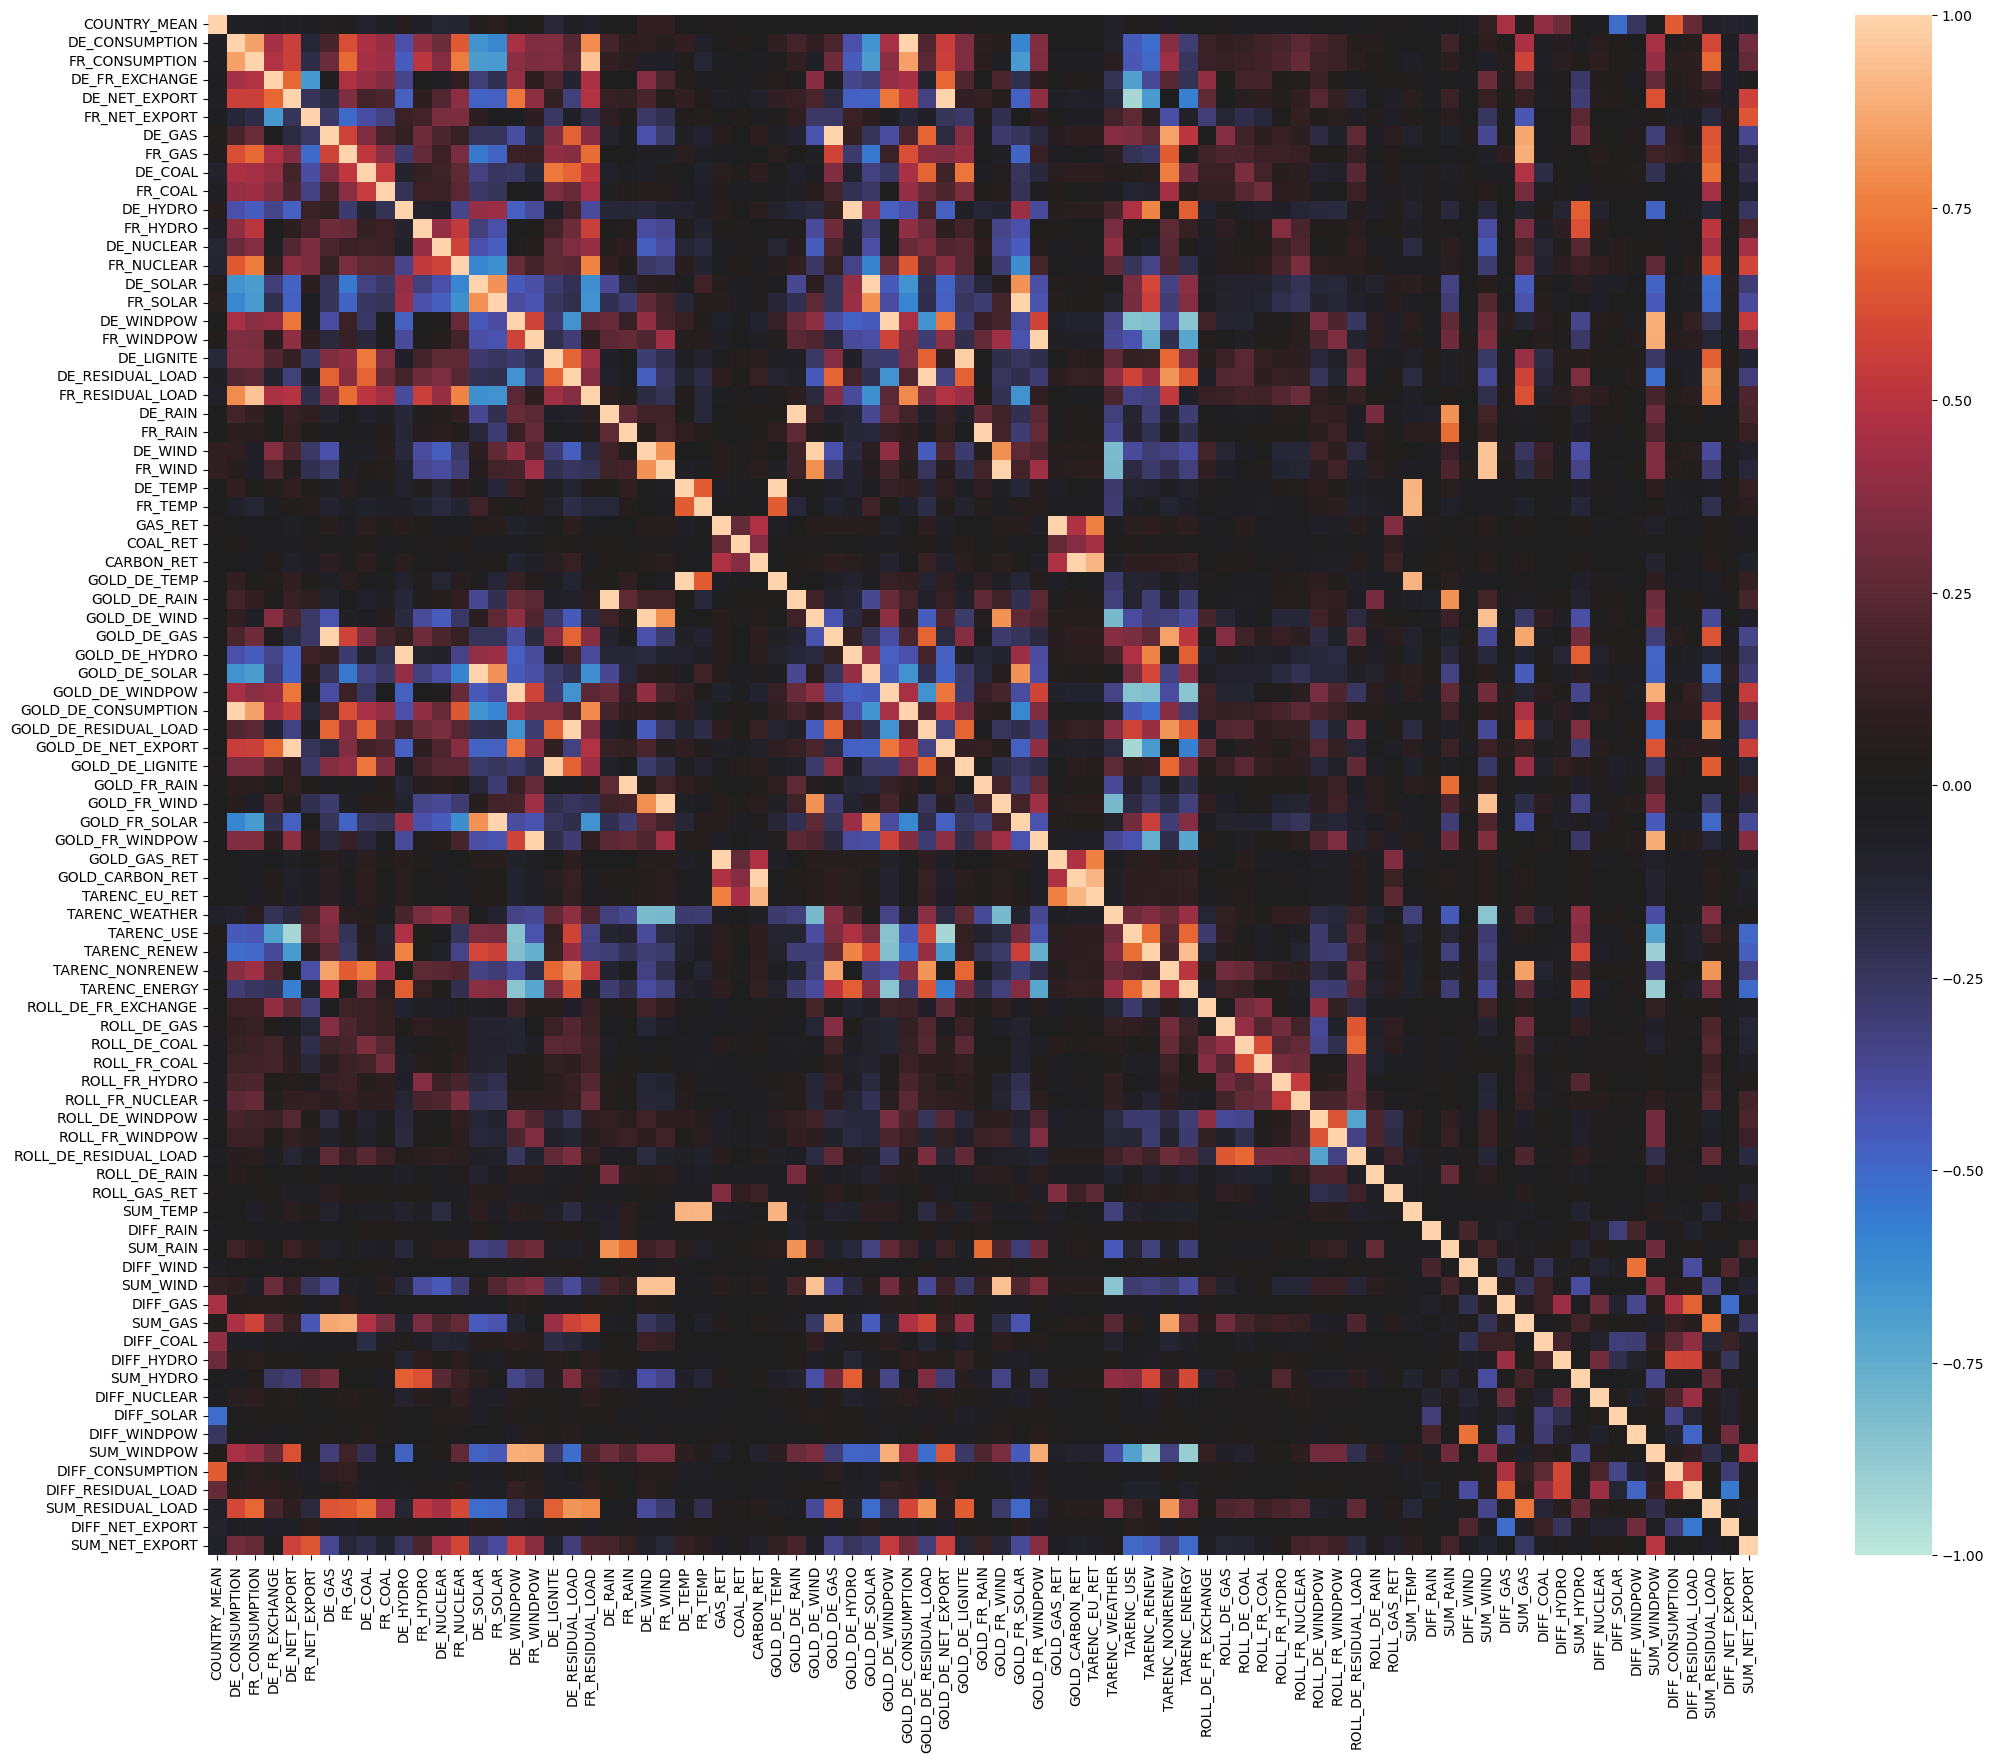

In [51]:
# plot heatmap of train and test data after feature creating
if UseTimeSeries:
    corr = X_trte_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

In [52]:
# top correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:60]
pd_pairs_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
pd_pairs_high_corr = pd_pairs_corr[pd_pairs_corr['|r|'] >= corr_threshold]
display(pd_pairs_high_corr)

feat1                  feat2       |r|         r
0           DE_WINDPOW        GOLD_DE_WINDPOW  0.999983  0.999983
1           CARBON_RET        GOLD_CARBON_RET  0.999982  0.999982
2              FR_RAIN           GOLD_FR_RAIN  0.999971  0.999971
3              DE_RAIN           GOLD_DE_RAIN  0.999945  0.999945
4              DE_TEMP           GOLD_DE_TEMP  0.999912  0.999912
5              GAS_RET           GOLD_GAS_RET  0.999740  0.999740
6           FR_WINDPOW        GOLD_FR_WINDPOW  0.999287  0.999287
7               DE_GAS            GOLD_DE_GAS  0.999255  0.999255
8             DE_SOLAR          GOLD_DE_SOLAR  0.999065  0.999065
9             DE_HYDRO          GOLD_DE_HYDRO  0.998462  0.998462
10       DE_NET_EXPORT     GOLD_DE_NET_EXPORT  0.997997  0.997997
11    DE_RESIDUAL_LOAD  GOLD_DE_RESIDUAL_LOAD  0.997874  0.997874
12      DE_CONSUMPTION    GOLD_DE_CONSUMPTION  0.997869  0.997869
13            FR_SOLAR          GOLD_FR_SOLAR  0.997866  0.997866
14             FR_WIND           GOLD_FR_WIND  0.992369  0.992369
15             DE_WIND           GOLD_DE_WIND  0.991926  0.991926
16          DE_LIGNITE        GOLD_DE_LIGNITE  0.981903  0.981903
17             FR_WIND               SUM_WIND  0.948819  0.948819
18             DE_WIND               SUM_WIND  0.948039  0.948039
19      FR_CONSUMPTION       FR_RESIDUAL_LOAD  0.946473  0.946473
20        GOLD_FR_WIND               SUM_WIND  0.940227  0.940227
21        GOLD_DE_WIND               SUM_WIND  0.939237  0.939237
22       DE_NET_EXPORT             TARENC_USE  0.934386 -0.934386
23  GOLD_DE_NET_EXPORT             TARENC_USE  0.934309 -0.934309
24        TARENC_RENEW          TARENC_ENERGY  0.933237  0.933237
25             FR_TEMP               SUM_TEMP  0.913330  0.913330
26          CARBON_RET          TARENC_EU_RET  0.907528  0.907528
27     GOLD_CARBON_RET          TARENC_EU_RET  0.907448  0.907448
28             DE_TEMP               SUM_TEMP  0.905008  0.905008
29        GOLD_DE_TEMP               SUM_TEMP  0.904933  0.904933
30        TARENC_RENEW            SUM_WINDPOW  0.901930 -0.901930
31       TARENC_ENERGY            SUM_WINDPOW  0.895501 -0.895501
32              FR_GAS                SUM_GAS  0.887075  0.887075
33          DE_WINDPOW            SUM_WINDPOW  0.885274  0.885274
34     GOLD_DE_WINDPOW            SUM_WINDPOW  0.885215  0.885215
35          FR_WINDPOW            SUM_WINDPOW  0.876823  0.876823
36     GOLD_FR_WINDPOW            SUM_WINDPOW  0.876544  0.876544
37              DE_GAS                SUM_GAS  0.873264  0.873264
38         GOLD_DE_GAS                SUM_GAS  0.873043  0.873043
39          DE_WINDPOW          TARENC_ENERGY  0.854826 -0.854826
40     GOLD_DE_WINDPOW          TARENC_ENERGY  0.854806 -0.854806
41         GOLD_DE_GAS        TARENC_NONRENEW  0.854631  0.854631
42      TARENC_WEATHER               SUM_WIND  0.853431 -0.853431
43              DE_GAS        TARENC_NONRENEW  0.852294  0.852294
44     TARENC_NONRENEW                SUM_GAS  0.850328  0.850328

In [53]:
# determine drop list according to highly correlated features
drop_pairs = []

for idx, data in pd_pairs_high_corr.iterrows():
    drop_fea = ''

    if (data.feat1 not in drop_pairs) and (data.feat2 not in drop_pairs):
        if (data.feat1 not in num_cols) and (data.feat2 in num_cols):
            drop_fea = data.feat1
        elif (data.feat1 in num_cols) and (data.feat2 not in num_cols):
            drop_fea = data.feat2
        elif (data.feat1 not in num_cols) and (data.feat2 not in num_cols):
            if target_corr[data.feat1] < target_corr[data.feat2]:
                drop_fea = data.feat1
            elif target_corr[data.feat1] > target_corr[data.feat2]:
                drop_fea = data.feat2
            elif mi_series[data.feat1] < mi_series[data.feat2]:
                drop_fea = data.feat1
            else:
                drop_fea = data.feat2

    if drop_fea != '':
        drop_pairs.append(drop_fea)

display(drop_pairs)

['GOLD_DE_WINDPOW',
 'GOLD_CARBON_RET',
 'GOLD_FR_RAIN',
 'GOLD_DE_RAIN',
 'GOLD_DE_TEMP',
 'GOLD_GAS_RET',
 'GOLD_FR_WINDPOW',
 'GOLD_DE_GAS',
 'GOLD_DE_SOLAR',
 'GOLD_DE_HYDRO',
 'GOLD_DE_NET_EXPORT',
 'GOLD_DE_RESIDUAL_LOAD',
 'GOLD_DE_CONSUMPTION',
 'GOLD_FR_SOLAR',
 'GOLD_FR_WIND',
 'GOLD_DE_WIND',
 'GOLD_DE_LIGNITE',
 'SUM_WIND',
 'TARENC_USE',
 'TARENC_RENEW',
 'SUM_TEMP',
 'TARENC_EU_RET',
 'SUM_WINDPOW',
 'SUM_GAS',
 'TARENC_ENERGY',
 'TARENC_NONRENEW']

In [54]:
# remove the selected features
drop_features += drop_pairs
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

In [55]:
# plot heatmap of train data with target
if not UseTimeSeries:
    corr = Xy_tr_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

Correlation matrix shape: (57, 57)


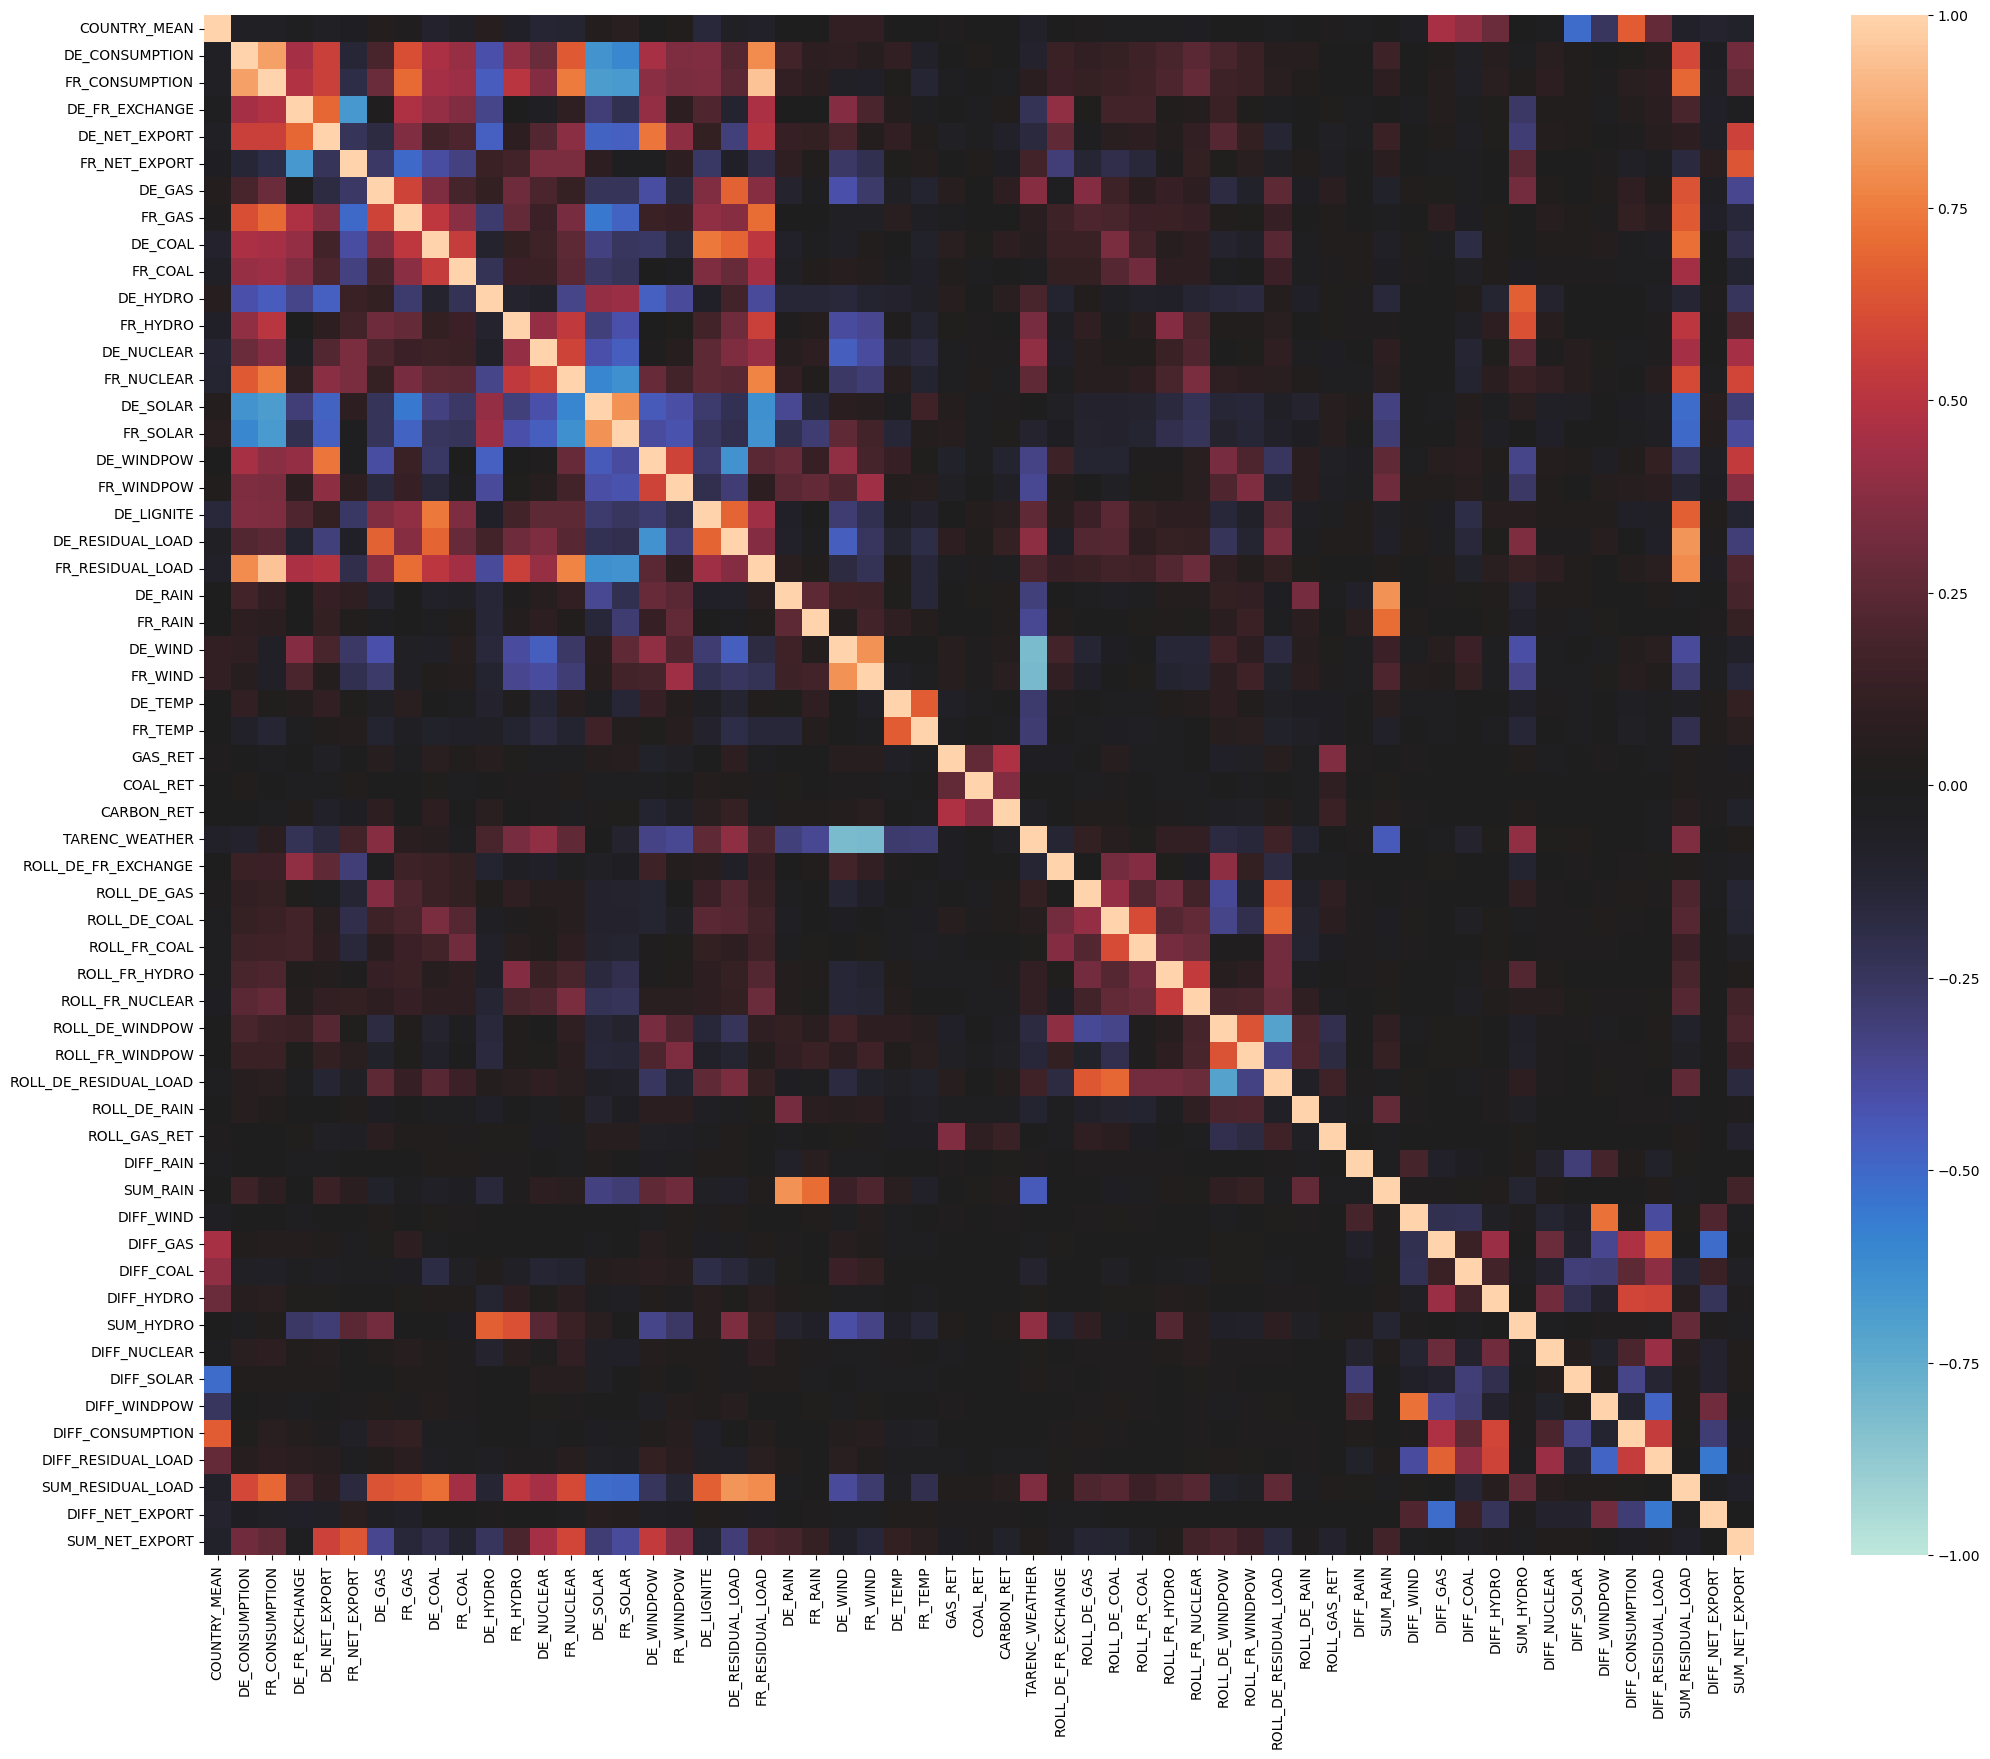

In [56]:
# plot heatmap of train and test data after feature creating
if UseTimeSeries:
    corr = X_trte_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])
    print("Correlation matrix shape:", corr.shape)
    
    plt.figure(figsize=[25,20])
    sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
    plt.show()

In [57]:
# check if there are still highly correlated pairs
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:60]
pd_pairs_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
pd_pairs_high_corr = pd_pairs_corr[pd_pairs_corr['|r|'] >= corr_threshold]
print(f"there are {len(pd_pairs_high_corr)} highly correlated pairs.") 

there are 1 highly correlated pairs.


### 5.3 Selection according to feature outliers

In [58]:
# count the columns with a large number of missing and outlier values
c_outlier = column_missing_and_outliers(Xy_tr_finished)
drop_c_outlier = list(c_outlier.loc[(c_outlier.n_missing + c_outlier.n_outliers) > missing_outlier_c_threshold].index)
print(f"The number of columns with a large count of outlier values is {len(drop_c_outlier)}")
if 'TARGET' in drop_c_outlier:
    drop_c_outlier.remove('TARGET')
drop_columns += drop_c_outlier
drop_columns = list(set(drop_columns))
display(drop_columns)

The number of columns with a large count of outlier values is 1


['FR_COAL']

In [59]:
# remove the columns with a large number of missing and outlier values
display((X_train.shape, X_test.shape, X_trte_finished.shape, Xy_tr_finished.shape))
drop_columns_large = [x for x in drop_columns if x in X_trte_finished.columns]
drop_columns_small = [x for x in drop_columns if x in X_train.columns]

if (not OnlyOrigNumFeatures) and RemoveMissingOutlier and len(drop_columns_small) > 0:
    X_train = X_train.drop(drop_columns_small, axis=1)
    X_test = X_test.drop(drop_columns_small, axis=1)

if (not OnlyOrigNumFeatures) and RemoveMissingOutlier and len(drop_columns_large) > 0:
    X_trte_finished = X_trte_finished.drop(drop_columns_large, axis=1)
    Xy_tr_finished = Xy_tr_finished.drop(drop_columns_large, axis=1)
    num_cols = [x for x in num_cols if x not in drop_columns]

display((X_train.shape, X_test.shape, X_trte_finished.shape, Xy_tr_finished.shape))

((1459, 35), (654, 32), (2113, 58), (1459, 59))

((1459, 35), (654, 32), (2113, 58), (1459, 59))

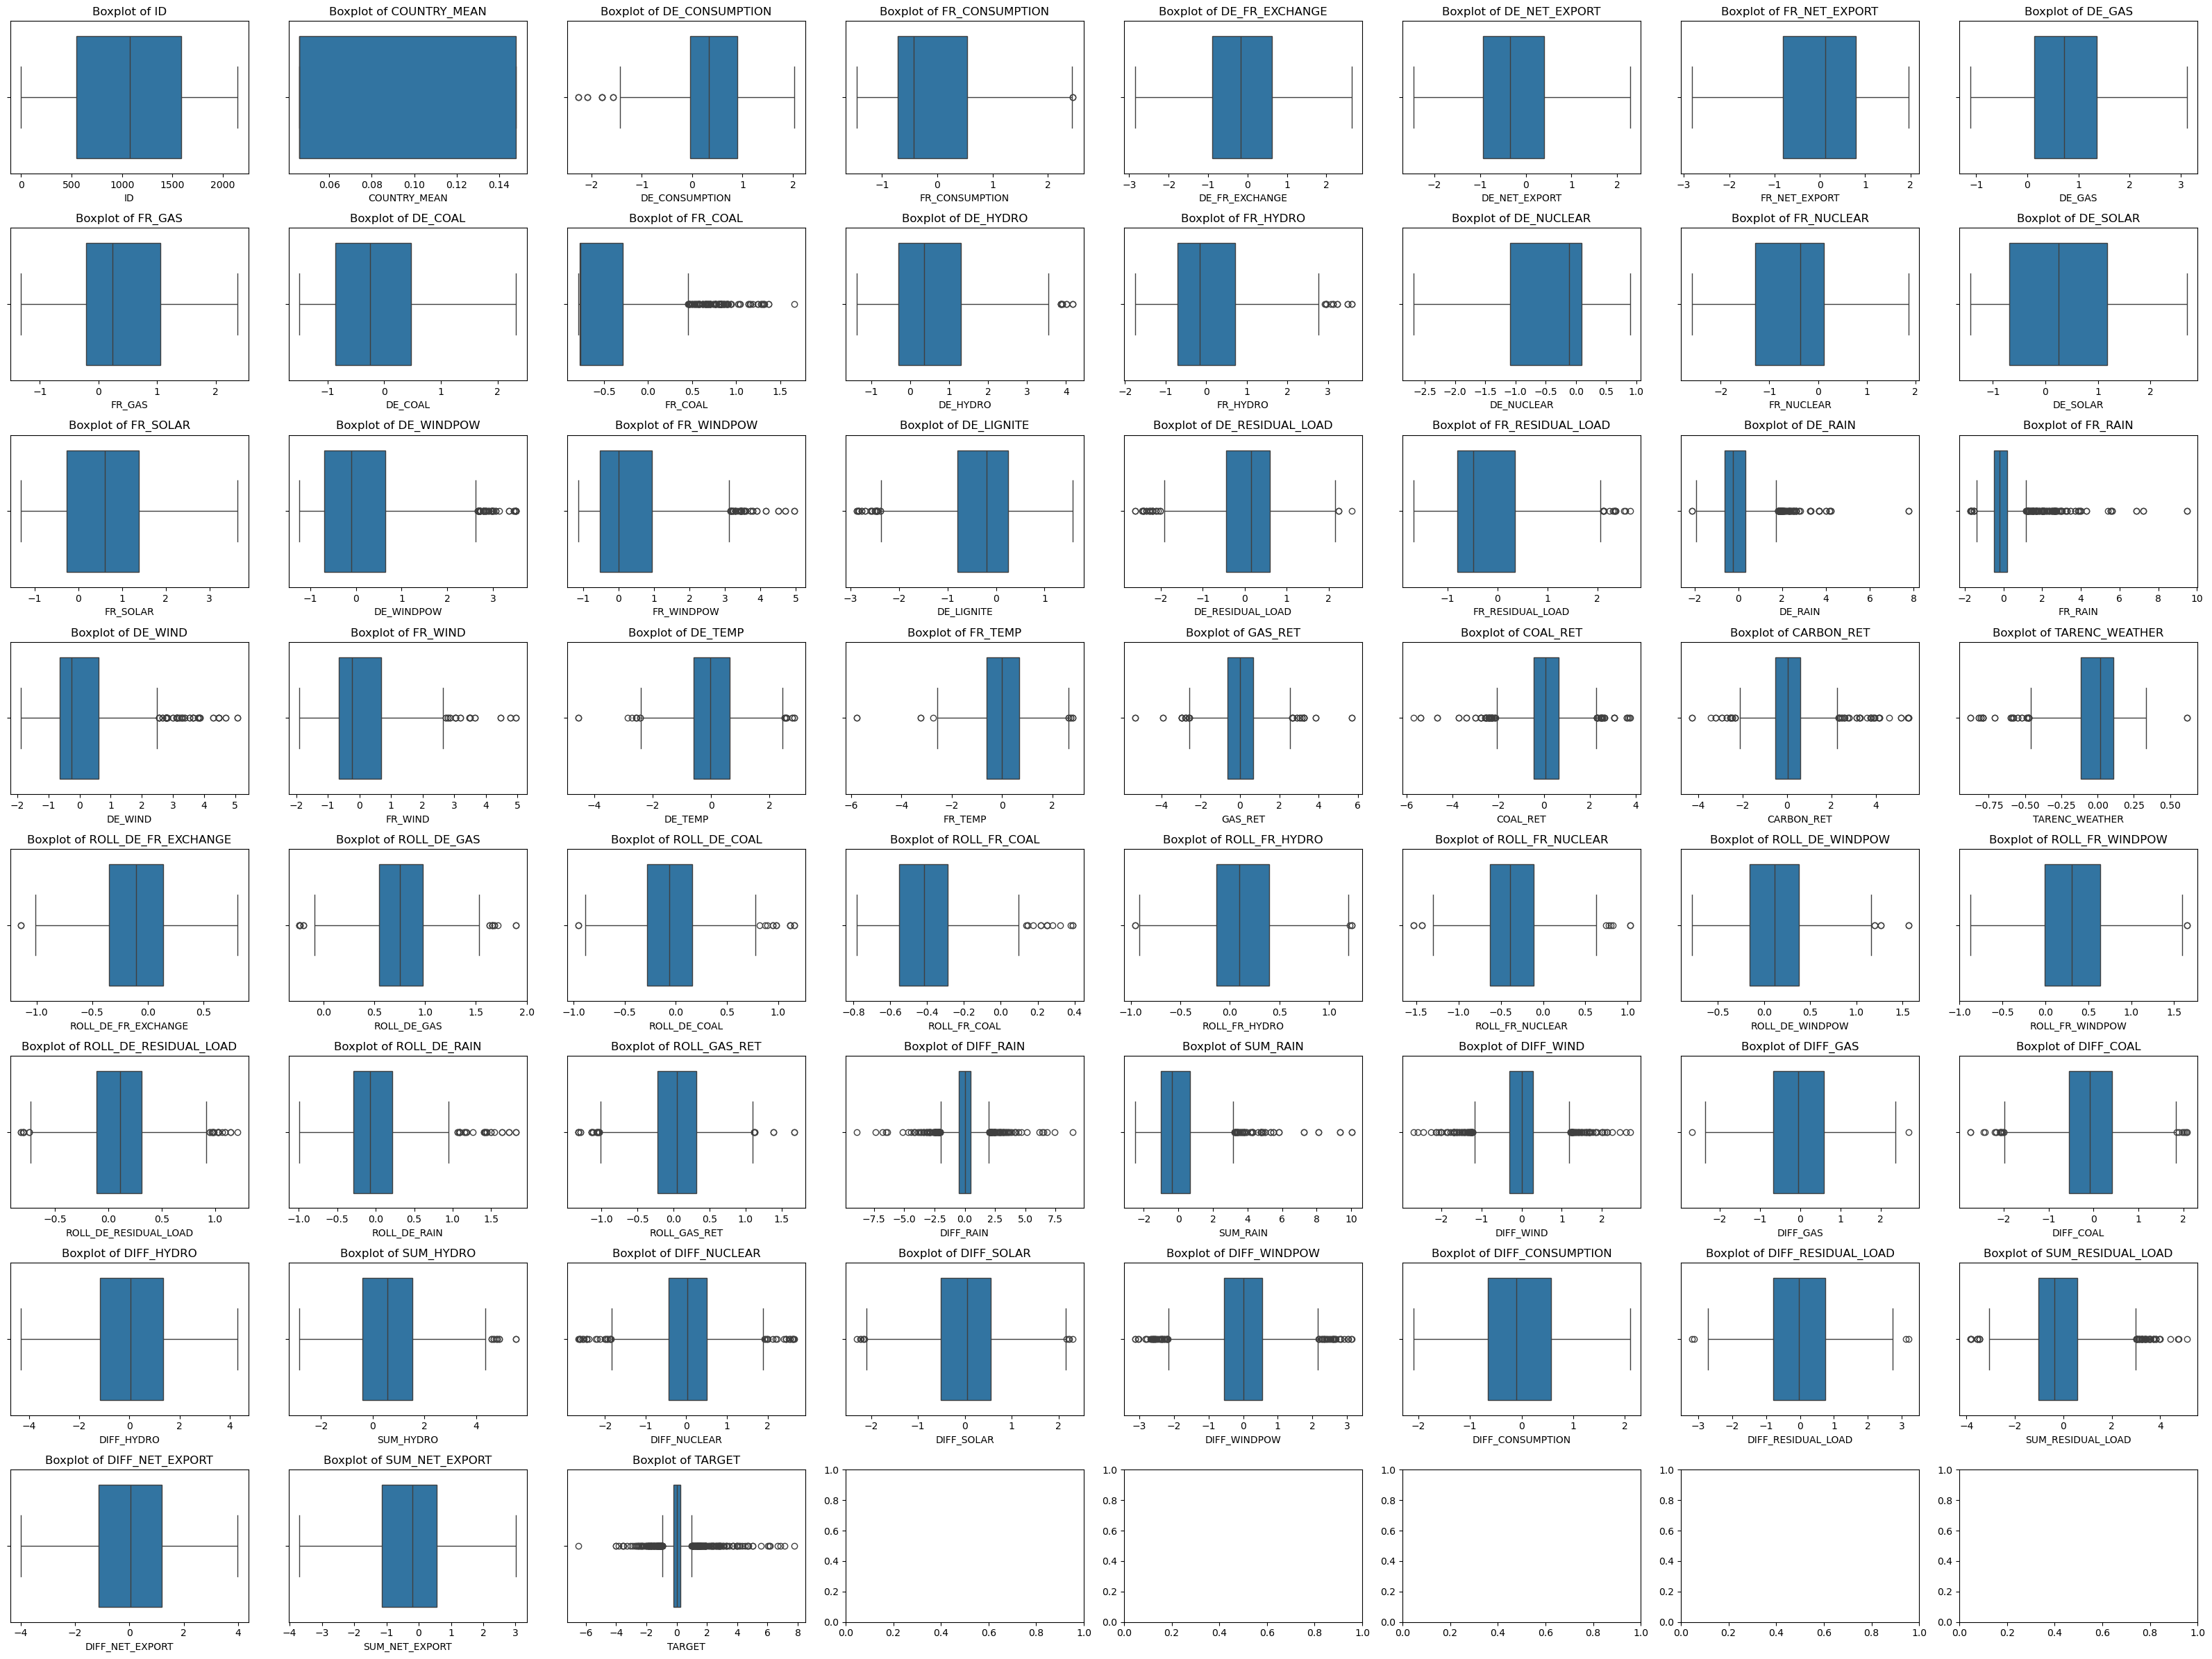

In [60]:
# plot the outliers for each feature
plots = [(c, Xy_tr_finished[c]) for c in Xy_tr_finished.columns]

K = len(plots)
N = math.ceil(math.sqrt(K))            
M = math.ceil(K / N)                 

fig, axes = plt.subplots(M, N, figsize=(N*4, M*3), squeeze=False)
axes = axes.ravel()

for i, (name, s) in enumerate(plots):
    sns.boxplot(x=s, ax=axes[i])
    axes[i].set_title(f"Boxplot of {name}")

plt.tight_layout()
plt.show()

### 5.4 Furture selection with null importance

Feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise. 

In [61]:
# create scoring function
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET']]
    # Go over fold and keep track of CV score (train and valid) and feature importances

    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)

        # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'verbose': -1,
        'n_jobs': 4
    }

    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = mean_squared_error(y, clf.predict(data[train_features]))

    return imp_df

In [62]:
# build the benchmark for feature importance
data = Xy_tr_finished
actual_imp_df = get_feature_importances(data=data, shuffle=False)

null_imp_df = pd.DataFrame()
nb_runs = 80
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)

In [63]:
# compute importance scores
feature_scores = []

for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])
scores_df = scores_df.sort_values('split_score', ascending=False)

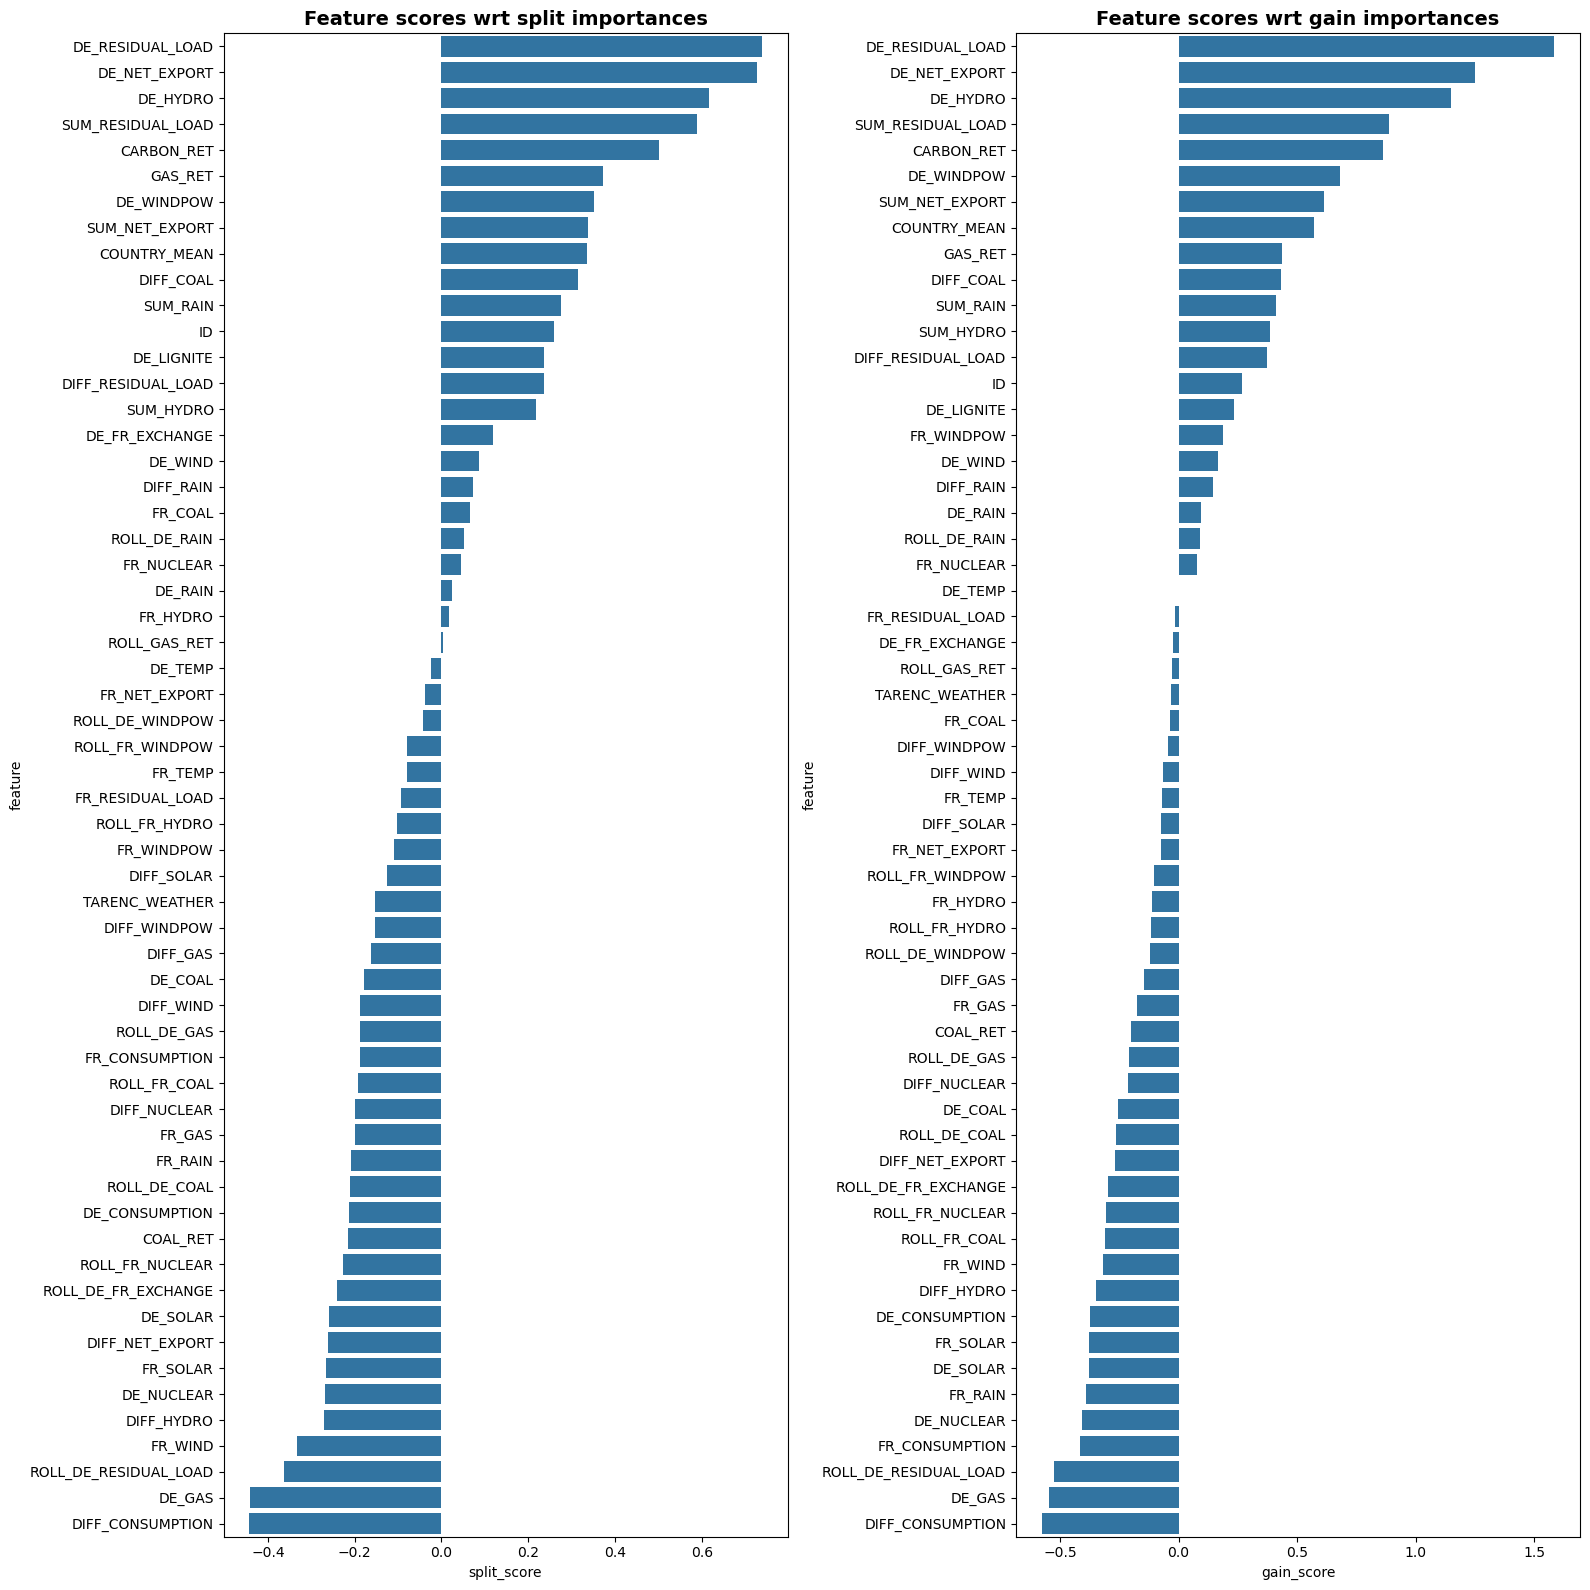

In [64]:
# plot null importances distribution
plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [65]:
# compute correlation scores
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

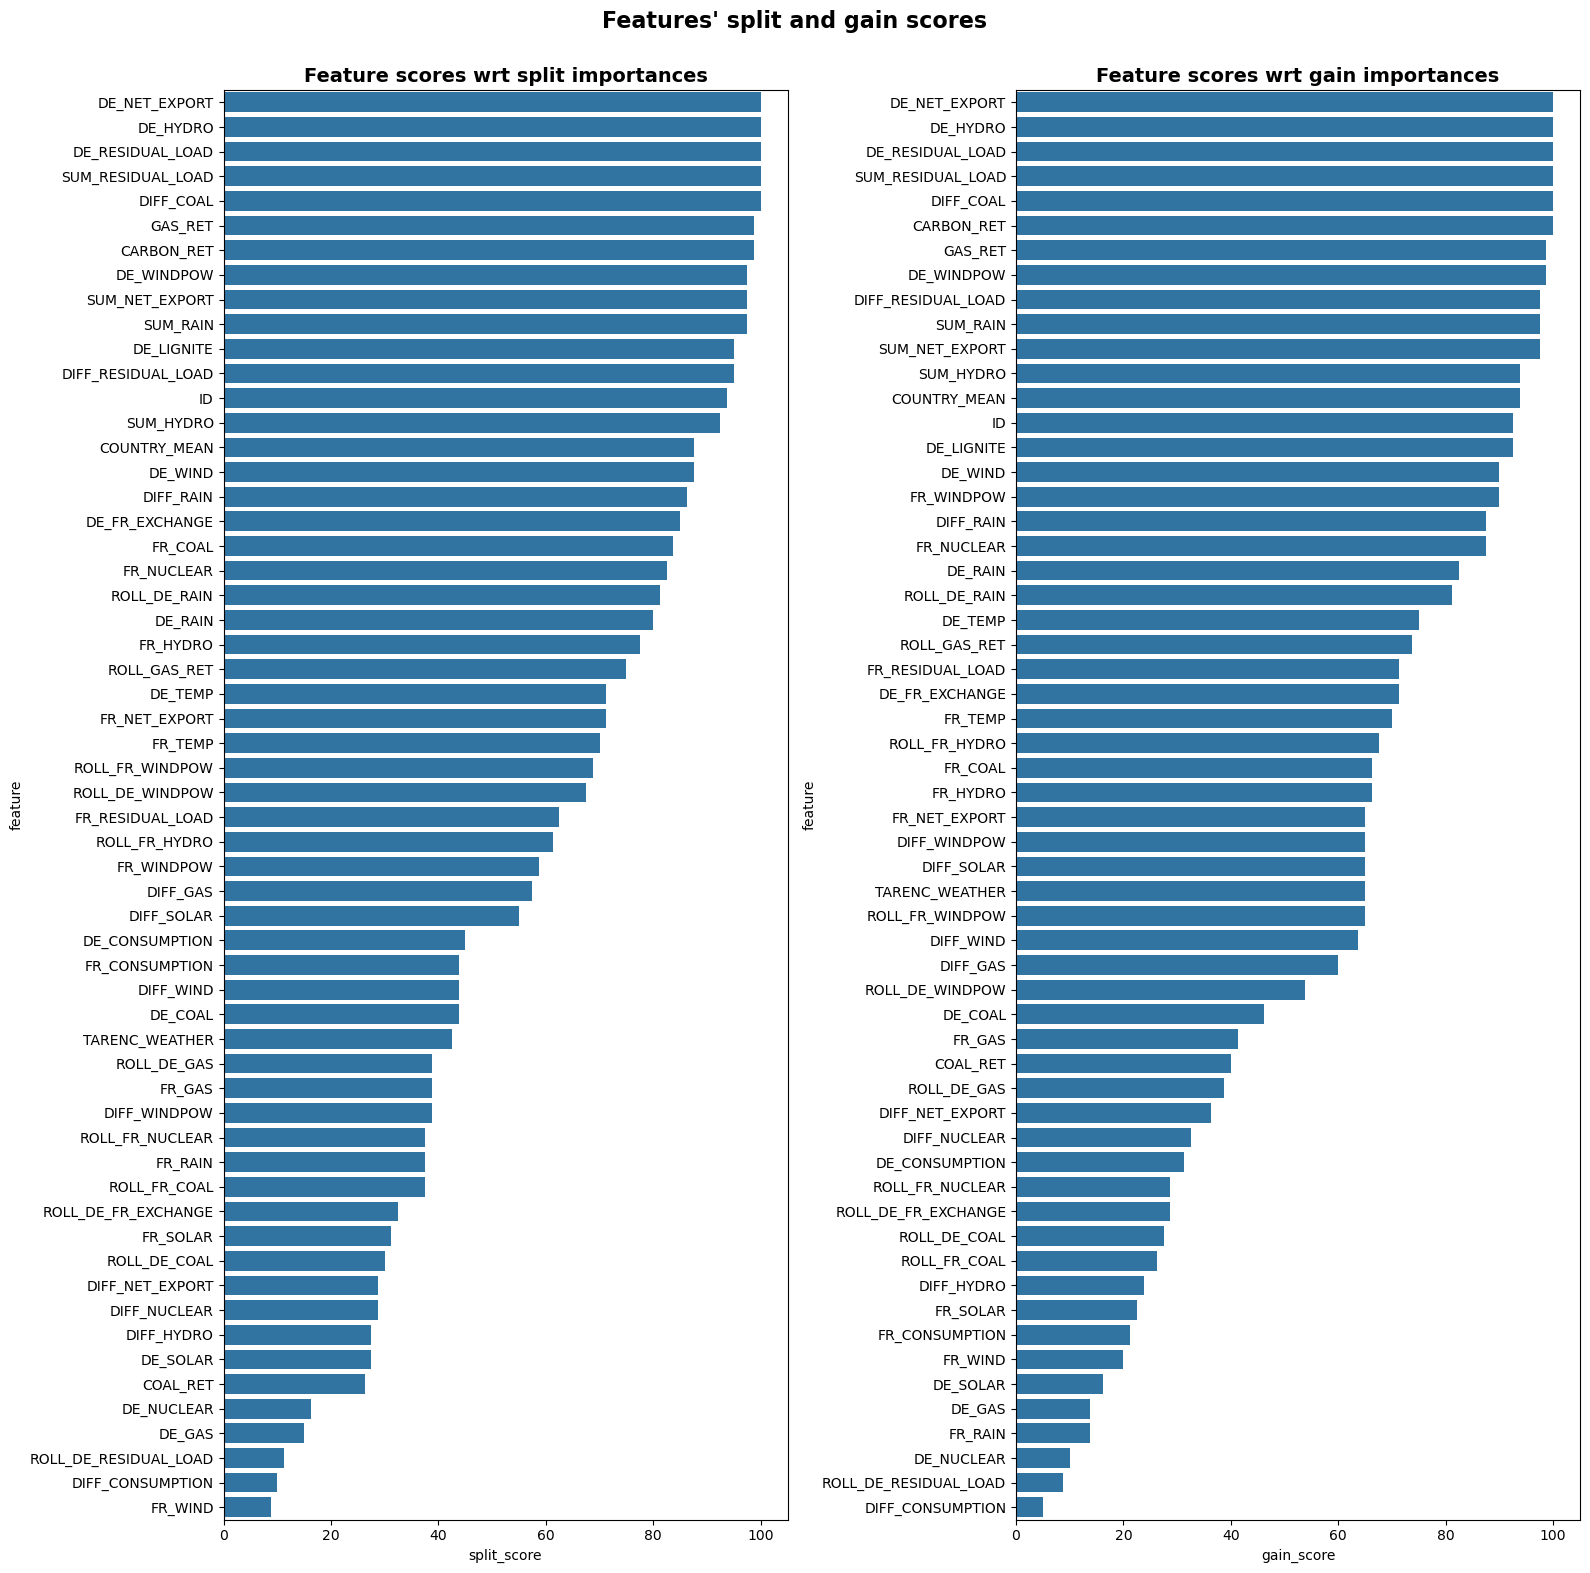

In [66]:
# plot features' split and gain scores
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [67]:
# determine the drop list based on null importance
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= null_importance_threshold]
gain_feats = [_f for _f, _, _score in correlation_scores if _score >= null_importance_threshold]
drop_null_importance = [x for x in split_feats if x in gain_feats]
display(drop_null_importance)

['ID',
 'DE_NET_EXPORT',
 'DE_HYDRO',
 'DE_WINDPOW',
 'DE_LIGNITE',
 'DE_RESIDUAL_LOAD',
 'GAS_RET',
 'CARBON_RET',
 'SUM_RAIN',
 'DIFF_COAL',
 'SUM_HYDRO',
 'DIFF_RESIDUAL_LOAD',
 'SUM_RESIDUAL_LOAD',
 'SUM_NET_EXPORT']

In [68]:
# remove selected fea
drop_features += drop_null_importance[1:]
if KeepOrigNumFeatures:
    drop_features = [x for x in drop_features if x not in orig_num_cols]

to_drop = [x for x in drop_features if x in X_trte_finished.columns]
if all(item in X_trte_finished.columns for item in to_drop):
    X_trte_finished.drop(to_drop, axis=1, inplace=True)  
    
Xy_tr_finished = pd.merge(X_trte_finished, y_train, on='ID', how='right')

## 6. Finalize and check the results of feature engineering

Correlation matrix shape: (51, 51)


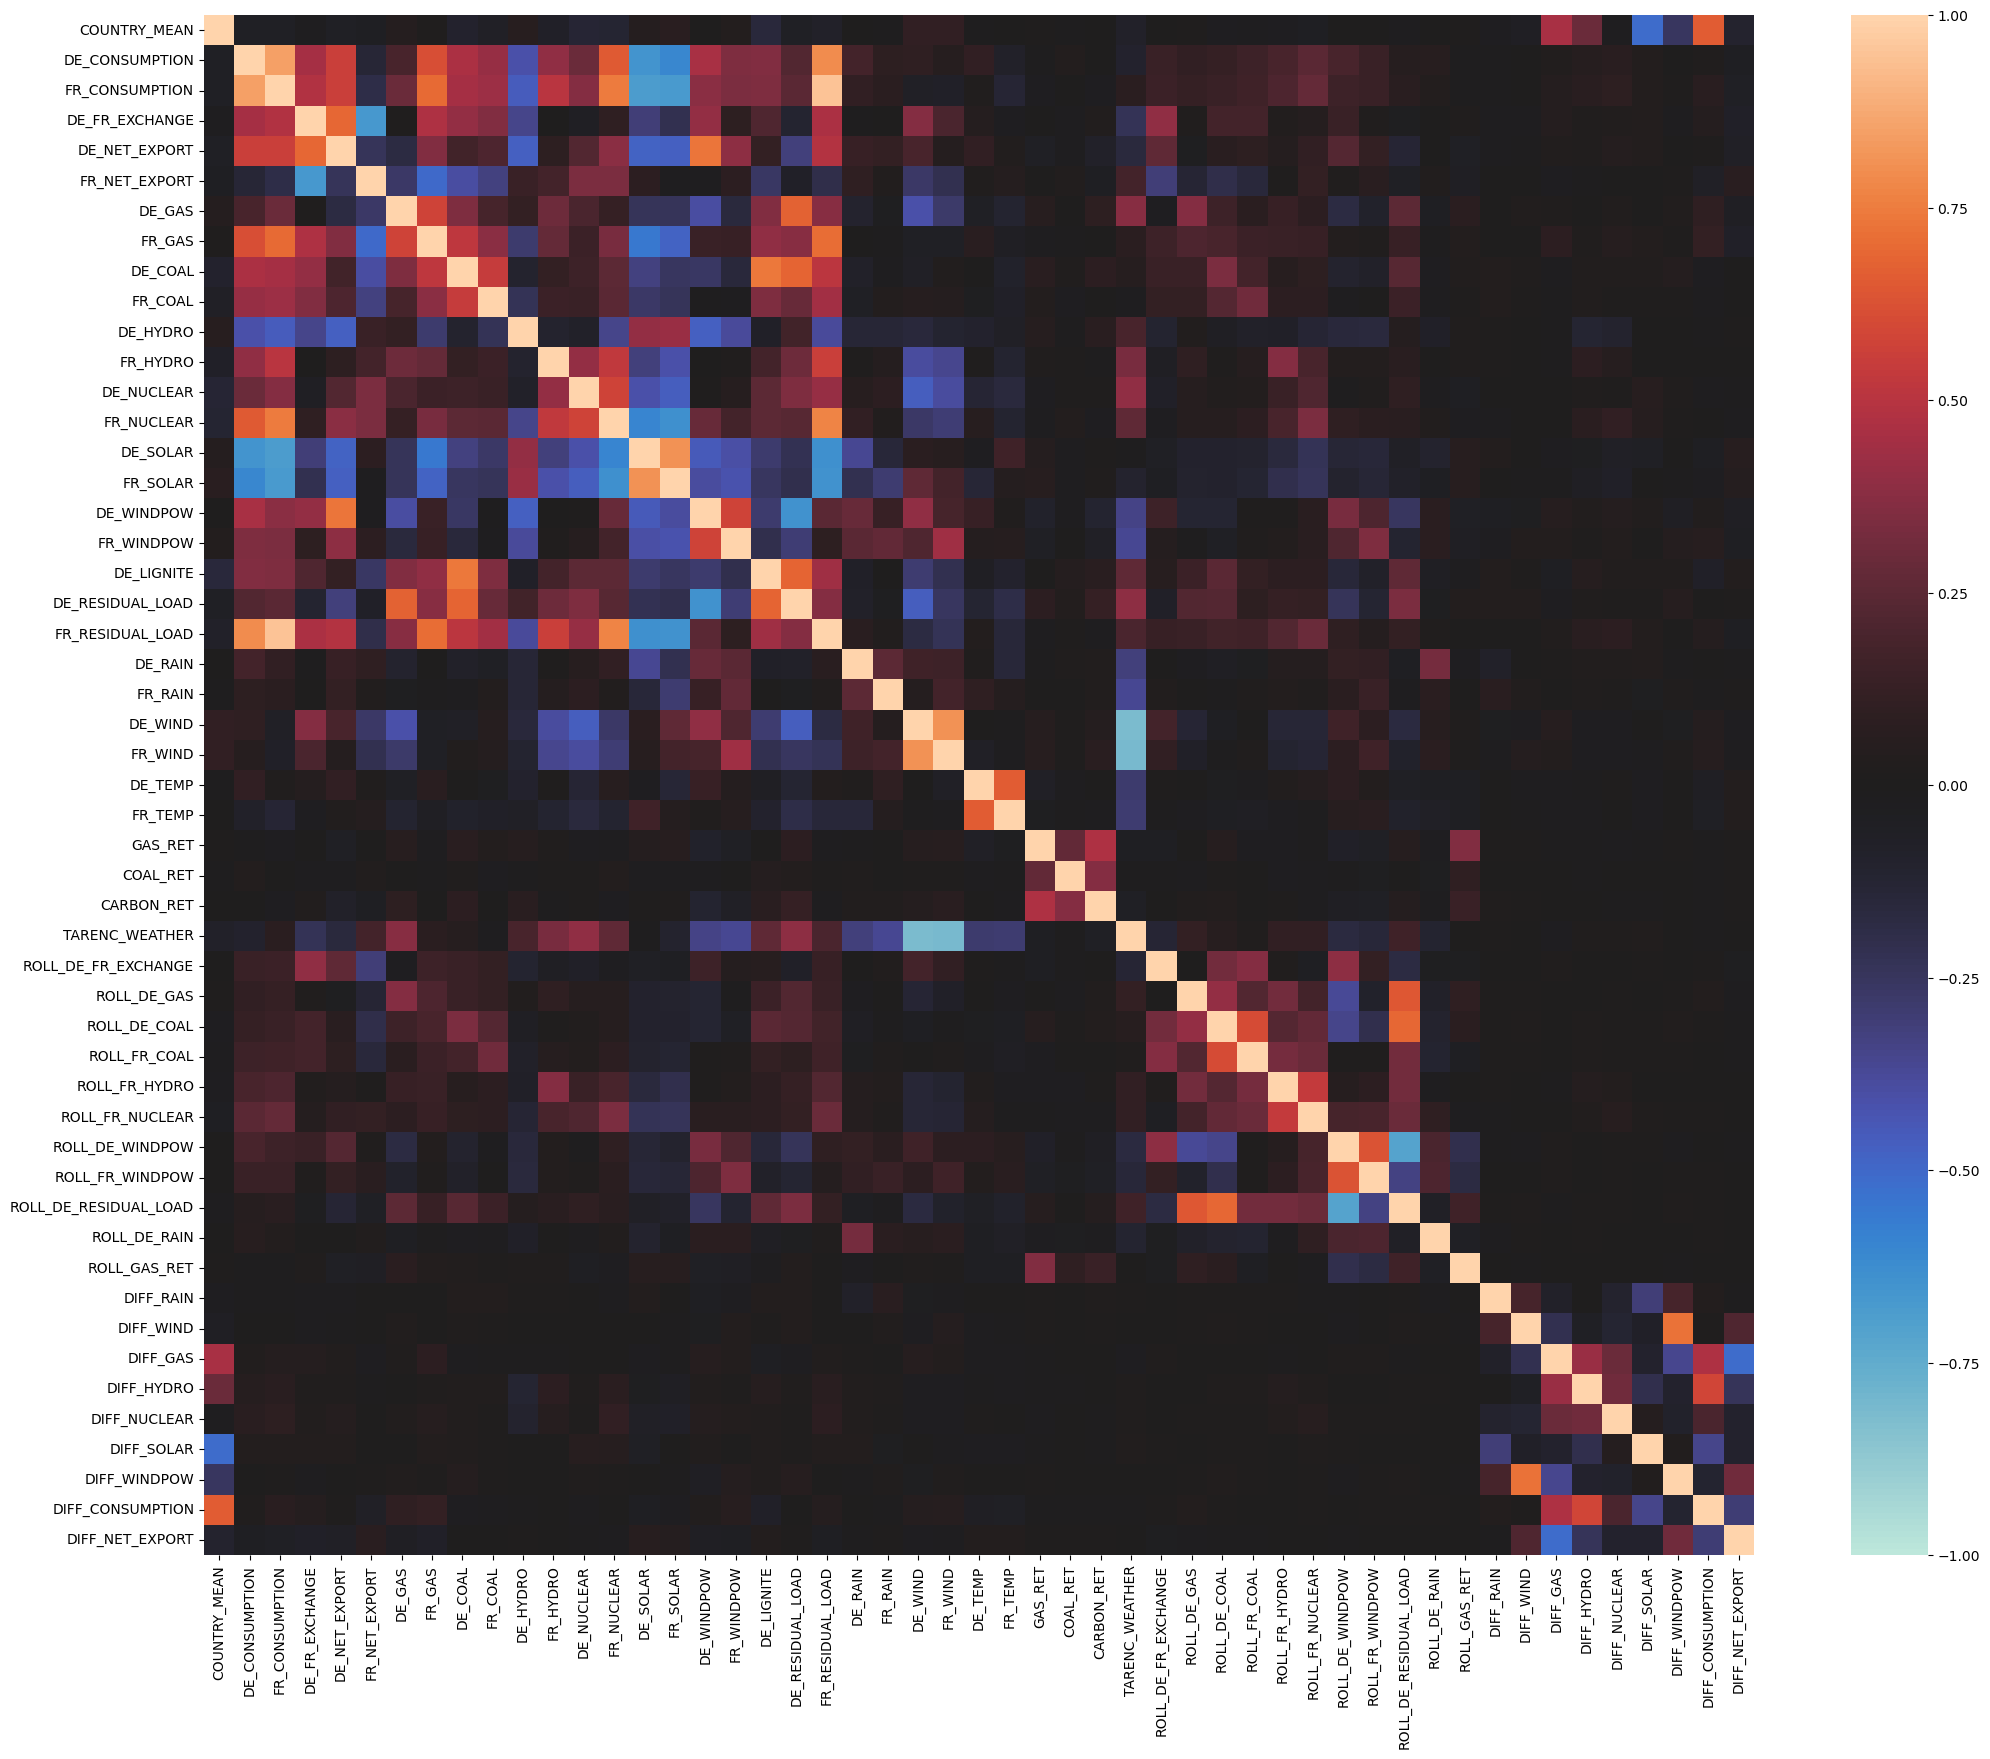

In [69]:
# plot heatmap of train and test data set after feature selection
corr = X_trte_finished.drop('ID', axis=1).corr(parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
plt.show()

In [70]:
# top correlated pairs by |r|
pairs = []
cols = corr.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr.iloc[i, j]
        pairs.append((cols[i], cols[j], abs(r), r))
pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:60]
pd_pairs_corr = pd.DataFrame(pairs_sorted, columns=["feat1", "feat2", "|r|", "r"])
pd_pairs_high_corr = pd_pairs_corr[pd_pairs_corr['|r|'] >= 0.80]
pd_pairs_high_corr

feat1             feat2       |r|         r
0  FR_CONSUMPTION  FR_RESIDUAL_LOAD  0.946473  0.946473
1  DE_CONSUMPTION    FR_CONSUMPTION  0.845925  0.845925
2         DE_WIND    TARENC_WEATHER  0.813199 -0.813199
3        DE_SOLAR          FR_SOLAR  0.812114  0.812114
4         FR_WIND    TARENC_WEATHER  0.811566 -0.811566
5         DE_WIND           FR_WIND  0.809453  0.809453

Correlation matrix shape: (52, 52)


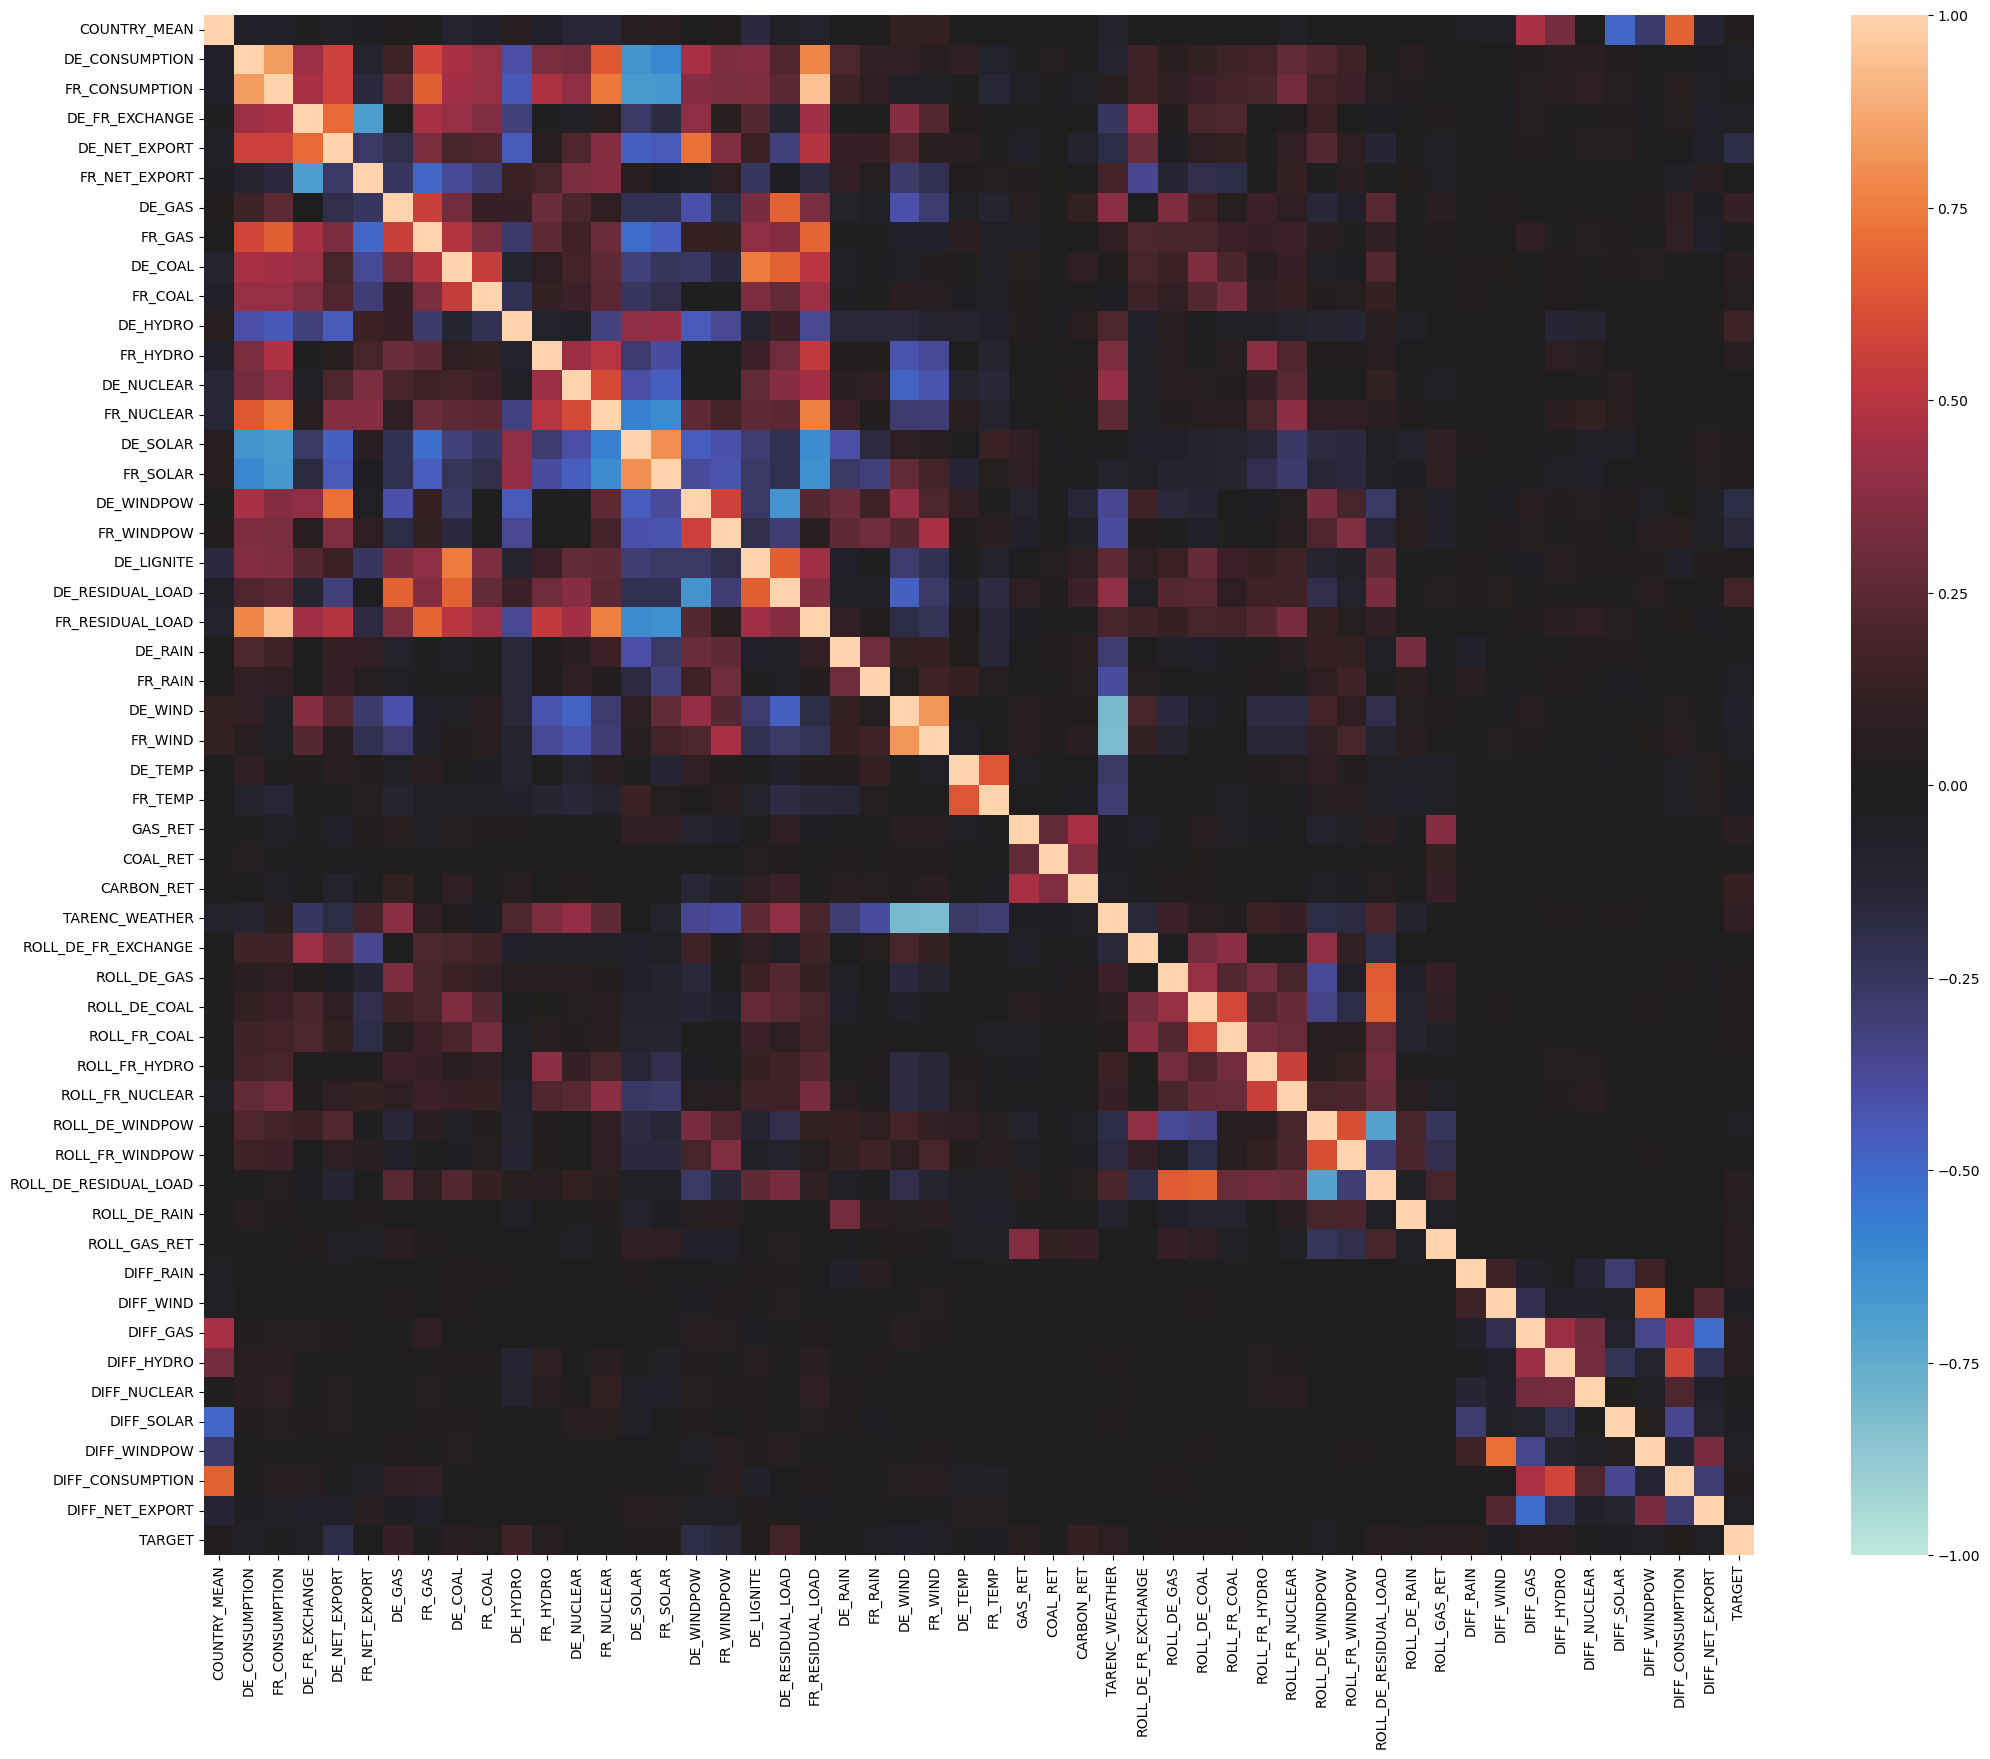

In [71]:
# plot heatmap of train data set with target after feature selection
corr = Xy_tr_finished.drop('ID', axis=1).corr(parameters['corr_method'])
print("Correlation matrix shape:", corr.shape)

plt.figure(figsize=[25,20])
sns.heatmap(corr, annot=False, vmin=-1, vmax=1, center=0) 
plt.show()

DE_RESIDUAL_LOAD         0.173904
DE_HYDRO                 0.155540
DE_GAS                   0.126673
CARBON_RET               0.120927
TARENC_WEATHER           0.080407
GAS_RET                  0.070996
DE_COAL                  0.066406
FR_HYDRO                 0.060309
ROLL_DE_RESIDUAL_LOAD    0.057045
DIFF_GAS                 0.053036
DIFF_HYDRO               0.052839
ROLL_GAS_RET             0.051485
DIFF_RAIN                0.047310
ROLL_DE_RAIN             0.041515
FR_COAL                  0.041315
DE_SOLAR                 0.037432
DE_LIGNITE               0.035245
ROLL_DE_COAL             0.034300
FR_SOLAR                 0.033704
COUNTRY_MEAN             0.028346
ROLL_FR_COAL             0.028159
DIFF_CONSUMPTION         0.024892
ROLL_DE_GAS              0.023489
ROLL_FR_NUCLEAR          0.022881
ROLL_FR_HYDRO            0.020512
COAL_RET                 0.019586
FR_RESIDUAL_LOAD         0.014340
FR_GAS                   0.008651
DE_NUCLEAR               0.003714
FR_NET_EXPORT 

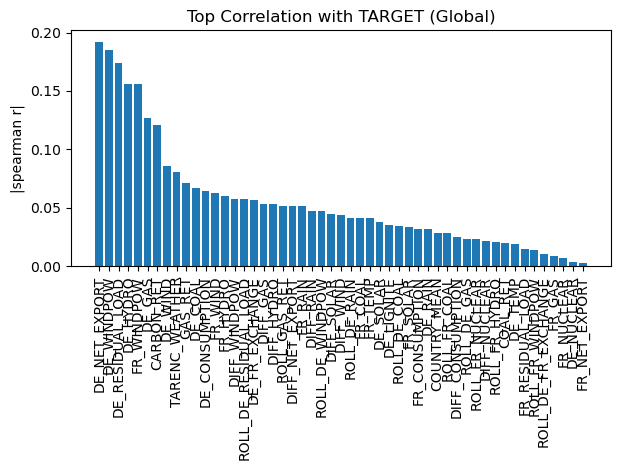

In [72]:
# plot high correlation with target
assert "TARGET" in Xy_tr_finished.columns, "TARGET missing after merge"
target_corr = Xy_tr_finished.drop('ID', axis=1).corr(method=parameters['corr_method'])["TARGET"].drop("TARGET").sort_values(ascending=False)
display(target_corr)

# bar of absolute correlations (top-k)
tc_abs = target_corr.abs().sort_values(ascending=False)
plt.figure()
plt.bar(tc_abs.index.astype(str), tc_abs.values)
plt.xticks(rotation=90)
plt.ylabel(f"|{parameters['corr_method']} r|")
plt.title("Top Correlation with TARGET (Global)")
plt.tight_layout()
plt.show()

DE_RESIDUAL_LOAD         0.065657
DE_WIND                  0.061411
FR_NET_EXPORT            0.054535
DE_WINDPOW               0.052669
DE_RAIN                  0.044555
DE_LIGNITE               0.041815
DE_GAS                   0.038839
ROLL_FR_NUCLEAR          0.028861
DIFF_WIND                0.027979
FR_CONSUMPTION           0.027231
FR_WINDPOW               0.026911
ROLL_DE_COAL             0.026510
ROLL_DE_RAIN             0.026484
ROLL_DE_FR_EXCHANGE      0.026325
DIFF_WINDPOW             0.025689
DE_TEMP                  0.025648
COUNTRY_MEAN             0.024911
DIFF_NUCLEAR             0.024774
FR_WIND                  0.023525
DIFF_SOLAR               0.022683
DIFF_CONSUMPTION         0.021187
DE_CONSUMPTION           0.019844
DE_NET_EXPORT            0.018823
DIFF_HYDRO               0.018609
DIFF_NET_EXPORT          0.018595
GAS_RET                  0.018572
ROLL_FR_HYDRO            0.018439
FR_SOLAR                 0.018012
CARBON_RET               0.016848
FR_NUCLEAR    

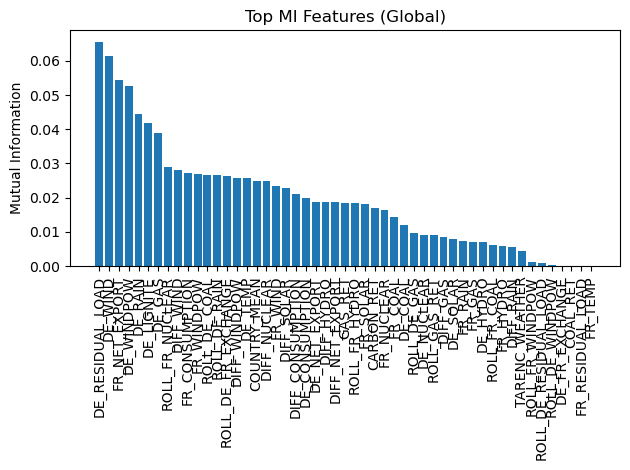

In [73]:
# plot mutual information ranking (top-k)
mi = mutual_info_regression(Xy_tr_finished.drop(['ID', 'TARGET'], axis=1), Xy_tr_finished['TARGET'], random_state=RANDOM_STATE)
mi_series = pd.Series(mi, index=Xy_tr_finished.columns[1:-1]).sort_values(ascending=False)
display(mi_series)

plt.figure()
plt.bar(mi_series.index.astype(str), mi_series.values)
plt.xticks(rotation=90)
plt.ylabel("Mutual Information")
plt.title("Top MI Features (Global)")
plt.tight_layout()
plt.show()

In [74]:
# finalize the engineered data set
if OnlyOrigNumFeatures:
    remain_features = [x for x in X_trte_finished.columns if x in orig_num_cols]
    X_trte_finished = X_trte_finished[remain_features]
    X_trte_finished['DE_NET_IMPORT'] = -1 * X_trte_finished['DE_NET_EXPORT']
    X_trte_finished['FR_NET_IMPORT'] = -1 * X_trte_finished['FR_NET_EXPORT']
    X_trte_finished['FR_DE_EXCHANGE'] = -1 * X_trte_finished['DE_FR_EXCHANGE']

X_train_clean = X_train[['ID']].merge(X_trte_finished, on='ID', how='left')
X_test_clean = X_test[['ID']].merge(X_trte_finished, on='ID', how='left')

print("Missing value count:", X_train_clean.isna().sum().sum() + X_test_clean.isna().sum().sum())
display(X_train_clean.shape)
display(X_test_clean.shape)
display(y_train.shape)

Missing value count: 0


(1459, 33)

(654, 33)

(1459, 2)

## 7. Evaluate the feature engineering result with ML prediction

In [75]:
# TabPFN regression
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train_clean, y_train['TARGET'], test_size=0.15, random_state=RANDOM_STATE)

tabpfn_regressor = TabPFNRegressor(random_state=42, device="cuda")
tabpfn_regressor.fit(X_train_.to_numpy(), y_train_.to_numpy())
test_pred = tabpfn_regressor.predict(X_test_)

mse = mean_squared_error(y_test_, test_pred)
spearman = spearmanr(y_test_, test_pred).correlation
r2 = r2_score(y_test_, test_pred)

print(f"RMSE on test set: {mse:.4f}")
print(f"Spearmanon correlation on test set: {spearmanr(y_test_, test_pred).correlation}")

sb.glue("spearman", spearman)                 
sb.glue("r2", r2)  
sb.glue("X_train", X_train_clean)                 
sb.glue("y_train", y_train)  
sb.glue("X_test", X_test_clean)                 

RMSE on test set: 0.7123
Spearmanon correlation on test set: 0.29890091057616514
